# Semantica relation GRaph visualized

# Phase 1

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from matplotlib.patches import FancyArrowPatch
import random
from IPython.display import HTML
import io
import base64
from PIL import Image, ImageDraw
import os
import time
from tqdm import tqdm

# Set up the output directory structure
curr_dir = os.getcwd()
output_data_path = os.path.join(curr_dir + r"\..", "Data", "Output")

# Create the directory if it doesn't exist
os.makedirs(output_data_path, exist_ok=True)

# Define our word pairs (English-German)
word_pairs = [
    ('apple', 'Apfel'),
    ('dog', 'Hund'),
    ('cat', 'Katze'),
    ('tree', 'Baum'),
    ('house', 'Haus')
]

# Define sentence relations
# Format: (sentence_id, language, sentence, [(word, role)])
sentences = [
    # Apple sentences
    (1, 'english', "The apple is red", [('apple', 'subject'), ('red', 'property')]),
    (1, 'german', "Der Apfel ist rot", [('Apfel', 'subject'), ('rot', 'property')]),
    
    # Animal sentences
    (2, 'english', "The dog chases the cat", [('dog', 'agent'), ('cat', 'patient')]),
    (2, 'german', "Der Hund jagt die Katze", [('Hund', 'agent'), ('Katze', 'patient')]),
    
    # Location sentences
    (3, 'english', "The dog sleeps under the tree", [('dog', 'agent'), ('tree', 'location')]),
    (3, 'german', "Der Hund schläft unter dem Baum", [('Hund', 'agent'), ('Baum', 'location')]),
    
    # Property sentences
    (4, 'english', "The house is big", [('house', 'subject'), ('big', 'property')]),
    (4, 'german', "Das Haus ist groß", [('Haus', 'subject'), ('groß', 'property')]),
]

# Additional words from sentences
additional_words = {
    'red': {'type': 'property', 'emoji': '🔴'},
    'rot': {'type': 'property', 'emoji': '🔴'},
    'big': {'type': 'property', 'emoji': '📏'},
    'groß': {'type': 'property', 'emoji': '📏'},
}

# Types of words (for different shapes)
word_types = {
    'apple': 'fruit',
    'Apfel': 'fruit',
    'dog': 'animal',
    'Hund': 'animal',
    'cat': 'animal',
    'Katze': 'animal',
    'tree': 'plant',
    'Baum': 'plant',
    'house': 'object',
    'Haus': 'object',
    'red': 'property',
    'rot': 'property',
    'big': 'property',
    'groß': 'property',
}

# Emoji mappings
emoji_map = {
    'apple': '🍎',
    'dog': '🐕',
    'cat': '🐈',
    'tree': '🌳',
    'house': '🏠',
    'red': '🔴',
    'big': '📏',
}

# Colors based on language
language_colors = {
    'english': '#3498db',  # Blue
    'german': '#e74c3c'    # Red
}

# Colors based on word type
type_colors = {
    'fruit': '#2ecc71',    # Green
    'animal': '#9b59b6',   # Purple
    'plant': '#27ae60',    # Dark Green
    'object': '#f39c12',   # Orange
    'property': '#34495e', # Dark Gray
    'sentence': '#7f8c8d'  # Light Gray
}

# Colors based on role in sentence
role_colors = {
    'subject': '#1abc9c',  # Teal
    'property': '#9b59b6', # Purple
    'agent': '#e67e22',    # Orange
    'patient': '#3498db',  # Blue
    'location': '#2ecc71'  # Green
}

# Shape based on type
def get_node_shape(node_type):
    shapes = {
        'fruit': 'o',      # Circle
        'animal': 's',     # Square
        'plant': '^',      # Triangle
        'object': 'd',     # Diamond
        'property': 'p',   # Pentagon
        'sentence': 'h'    # Hexagon
    }
    return shapes.get(node_type, 'o')

# Create initial graph
def create_initial_graph():
    print("Creating initial semantic graph structure...")
    G = nx.Graph()
    
    # Add nodes for words
    for en, de in word_pairs:
        # English words
        G.add_node(en, 
                  lang='english',
                  type=word_types[en],
                  emoji=emoji_map[en],
                  color=language_colors['english'],
                  position=np.array([-1.5 + random.uniform(-0.1, 0.1), random.uniform(-0.8, 0.8)]),
                  merged=False,
                  size=300)
        
        # German words
        G.add_node(de, 
                  lang='german',
                  type=word_types[de],
                  emoji=emoji_map[en],  # Use English word for emoji mapping
                  color=language_colors['german'],
                  position=np.array([1.5 + random.uniform(-0.1, 0.1), random.uniform(-0.8, 0.8)]),
                  merged=False,
                  size=300)
    
    # Add additional words from sentences
    for word, info in additional_words.items():
        if word not in G:
            lang = 'english' if word in ['red', 'big'] else 'german'
            emoji_key = word if word in emoji_map else 'red' if word in ['rot'] else 'big'
            
            G.add_node(word,
                      lang=lang,
                      type=info['type'],
                      emoji=info['emoji'],
                      color=language_colors[lang],
                      position=np.array([-1.5 if lang == 'english' else 1.5, random.uniform(-0.8, 0.8)]),
                      merged=False,
                      size=300)
    
    # Add sentence nodes
    sentence_positions = {}
    for sent_id, lang, text, roles in sentences:
        node_id = f"sentence_{sent_id}_{lang}"
        x_pos = -1.0 if lang == 'english' else 1.0
        y_pos = 0.5 * sent_id
        
        sentence_positions[(sent_id, lang)] = np.array([x_pos, y_pos])
        
        G.add_node(node_id,
                  lang=lang,
                  type='sentence',
                  text=text,
                  color=type_colors['sentence'],
                  position=np.array([x_pos, y_pos]),
                  roles=roles,
                  merged=False,
                  size=400)
    
    print(f"Added {len(G.nodes)} nodes to the graph")
    return G, sentence_positions

# Add edges gradually in each frame
def update_graph(G, sentence_positions, frame, total_frames):
    progress = frame / total_frames
    
    # Phase 1: Add word-sentence relations (0-30% of frames)
    if progress <= 0.3:
        phase_progress = progress / 0.3
        
        # Process each sentence
        for sent_id, lang, text, roles in sentences:
            node_id = f"sentence_{sent_id}_{lang}"
            
            # Add edges from words to sentences
            for word, role in roles:
                if word in G.nodes and not G.has_edge(node_id, word):
                    # Determine if we should add this edge based on progress
                    role_idx = ['subject', 'property', 'agent', 'patient', 'location'].index(role) if role in ['subject', 'property', 'agent', 'patient', 'location'] else 0
                    threshold = 0.1 + (role_idx * 0.05)
                    
                    if phase_progress > threshold:
                        # Add edge with role information
                        edge_strength = min(1.0, (phase_progress - threshold) * 5)
                        G.add_edge(node_id, word, 
                                  role=role, 
                                  weight=edge_strength, 
                                  alpha=edge_strength,
                                  color=role_colors.get(role, 'gray'))
                
                # If edge exists, increase its strength
                elif G.has_edge(node_id, word):
                    G[node_id][word]['weight'] = min(2.0, G[node_id][word]['weight'] + 0.05)
                    G[node_id][word]['alpha'] = min(1.0, G[node_id][word]['alpha'] + 0.02)
    
    # Phase 2: Add cross-language word relations (30-60% of frames)
    if 0.3 < progress <= 0.6:
        phase_progress = (progress - 0.3) / 0.3
        
        # Add edges between equivalent words
        for i, (en, de) in enumerate(word_pairs):
            # Skip if already merged
            if G.nodes[en].get('merged') or G.nodes[de].get('merged'):
                continue
                
            # Calculate threshold based on word pair index
            threshold = i / len(word_pairs) * 0.8
            
            # Add the edge if we've progressed past the threshold for this pair
            if phase_progress > threshold:
                if not G.has_edge(en, de):
                    # Add the edge with increasing opacity and width
                    edge_strength = min(1.0, (phase_progress - threshold) * 5)
                    G.add_edge(en, de, weight=edge_strength, alpha=edge_strength, color='purple')
                else:
                    # Increase existing edge weight
                    current_weight = G[en][de]['weight']
                    G[en][de]['weight'] = min(3.0, current_weight + 0.1)
                    G[en][de]['alpha'] = min(1.0, G[en][de]['alpha'] + 0.05)
        
        # Add edges between additional word pairs
        additional_pairs = [('red', 'rot'), ('big', 'groß')]
        for i, (en, de) in enumerate(additional_pairs):
            if en in G.nodes and de in G.nodes:
                # Skip if already merged
                if G.nodes[en].get('merged') or G.nodes[de].get('merged'):
                    continue
                    
                # Calculate threshold
                threshold = 0.4 + (i / len(additional_pairs) * 0.4)
                
                # Add edge if we've progressed past threshold
                if phase_progress > threshold:
                    if not G.has_edge(en, de):
                        edge_strength = min(1.0, (phase_progress - threshold) * 5)
                        G.add_edge(en, de, weight=edge_strength, alpha=edge_strength, color='purple')
                    else:
                        G[en][de]['weight'] = min(3.0, G[en][de]['weight'] + 0.1)
                        G[en][de]['alpha'] = min(1.0, G[en][de]['alpha'] + 0.05)
    
    # Phase 3: Move nodes toward their equivalents (60-90% of frames)
    if 0.6 < progress <= 0.9:
        phase_progress = (progress - 0.6) / 0.3
        
        # Move word nodes toward their equivalents
        for i, (en, de) in enumerate(word_pairs + [('red', 'rot'), ('big', 'groß')]):
            if en in G.nodes and de in G.nodes:
                # Skip if already merged
                if G.nodes[en].get('merged') or G.nodes[de].get('merged'):
                    continue
                    
                # Calculate threshold
                threshold = i / (len(word_pairs) + 2) * 0.7
                
                # Move nodes if we've progressed past threshold
                if phase_progress > threshold and G.has_edge(en, de):
                    # Calculate target position (middle point with some variance)
                    en_pos = G.nodes[en]['position']
                    de_pos = G.nodes[de]['position']
                    
                    # Move gradually toward center
                    midpoint = (en_pos + de_pos) / 2
                    
                    # Speed up as we get closer to the end
                    move_factor = min(0.1, (phase_progress - threshold) * 0.3)
                    
                    G.nodes[en]['position'] = en_pos + (midpoint - en_pos) * move_factor
                    G.nodes[de]['position'] = de_pos + (midpoint - de_pos) * move_factor
                    
                    # Merge nodes if they're close enough
                    if np.linalg.norm(G.nodes[en]['position'] - G.nodes[de]['position']) < 0.2 and phase_progress > 0.9:
                        # Mark these nodes as merged
                        G.nodes[en]['merged'] = True
                        G.nodes[de]['merged'] = True
                        
                        # Visually indicate they're merged by making them small and transparent
                        G.nodes[en]['size'] = 0
                        G.nodes[de]['size'] = 0
                        G.nodes[en]['alpha'] = 0
                        G.nodes[de]['alpha'] = 0
                        
                        # Create merged emoji node
                        emoji = emoji_map.get(en, '❓')
                        merged_id = f"merged_{en}_{de}"
                        
                        G.add_node(merged_id,
                                  type='merged',
                                  emoji=emoji,
                                  position=midpoint,
                                  size=500,
                                  alpha=1.0,
                                  color='#1abc9c')  # Teal color for merged nodes
                        
                        # Copy all connections from original nodes to merged node
                        for neighbor in set(G.neighbors(en)).union(set(G.neighbors(de))):
                            if neighbor not in [en, de]:
                                # Get the edge with highest weight
                                weight1 = G.get_edge_data(en, neighbor, {'weight': 0})['weight'] if G.has_edge(en, neighbor) else 0
                                weight2 = G.get_edge_data(de, neighbor, {'weight': 0})['weight'] if G.has_edge(de, neighbor) else 0
                                
                                max_weight = max(weight1, weight2)
                                
                                if neighbor.startswith('sentence_'):
                                    # Get role information for sentence connections
                                    role = None
                                    if G.has_edge(en, neighbor):
                                        role = G.get_edge_data(en, neighbor).get('role', 'default')
                                    elif G.has_edge(de, neighbor):
                                        role = G.get_edge_data(de, neighbor).get('role', 'default')
                                    
                                    G.add_edge(merged_id, neighbor,
                                              weight=max_weight,
                                              alpha=1.0,
                                              role=role,
                                              color=role_colors.get(role, 'gray'))
                                else:
                                    G.add_edge(merged_id, neighbor,
                                              weight=max_weight,
                                              alpha=1.0,
                                              color='gray')
        
        # Move sentence nodes as well based on progress
        for sent_id, lang, text, roles in sentences:
            node_id = f"sentence_{sent_id}_{lang}"
            if node_id in G.nodes:
                # Move English sentences left, German sentences right
                x_target = -2.0 if lang == 'english' else 2.0
                y_target = sentence_positions[(sent_id, lang)][1]
                
                current_pos = G.nodes[node_id]['position']
                target_pos = np.array([x_target, y_target])
                
                # Calculate move factor based on progress
                move_factor = phase_progress * 0.1
                
                # Update position
                G.nodes[node_id]['position'] = current_pos + (target_pos - current_pos) * move_factor
    
    # Phase 4: Final stabilization (90-100% of frames)
    if progress > 0.9:
        # Add pulsating effect to merged nodes
        phase_progress = (progress - 0.9) / 0.1
        pulse = 1.0 + 0.2 * np.sin(phase_progress * 10 * np.pi)
        
        for node in list(G.nodes()):
            if node.startswith('merged_'):
                G.nodes[node]['size'] = 500 * pulse
    
    return G

# Draw the graph for animation
def draw_graph(G, ax, frame, total_frames):
    ax.clear()
    
    # Set up plot
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add title
    percentage = int((frame / total_frames) * 100)
    ax.set_title(f"Semantica: Cross-Lingual Relational Convergence - {percentage}%", fontsize=14)
    
    # Draw legend
    # Language Legend
    ax.text(-2.4, 1.3, "Languages:", fontsize=10, fontweight='bold')
    ax.plot(-2.3, 1.2, 'o', color=language_colors['english'], markersize=8)
    ax.text(-2.2, 1.2, "English", fontsize=9)
    ax.plot(-2.3, 1.1, 'o', color=language_colors['german'], markersize=8)
    ax.text(-2.2, 1.1, "German", fontsize=9)
    
    # Word Type Legend
    ax.text(-2.4, 0.9, "Word Types:", fontsize=10, fontweight='bold')
    
    shapes = {'fruit': 'o', 'animal': 's', 'plant': '^', 'object': 'd', 'property': 'p', 'sentence': 'h'}
    y_pos = 0.8
    for type_name, shape in shapes.items():
        ax.plot(-2.3, y_pos, shape, color=type_colors[type_name], markersize=8)
        ax.text(-2.2, y_pos, type_name, fontsize=9)
        y_pos -= 0.1
    
    # Relationship Role Legend
    ax.text(1.8, 1.3, "Relation Roles:", fontsize=10, fontweight='bold')
    
    y_pos = 1.2
    for role, color in role_colors.items():
        ax.plot([1.9, 2.1], [y_pos, y_pos], '-', color=color, linewidth=2)
        ax.text(2.2, y_pos, role, fontsize=9)
        y_pos -= 0.1
    
    # Draw edges
    for u, v, data in G.edges(data=True):
        # Skip edges connected to merged nodes (original words that merged)
        if (G.nodes[u].get('merged', False) and not u.startswith('merged_')) or \
           (G.nodes[v].get('merged', False) and not v.startswith('merged_')):
            continue
            
        pos1 = G.nodes[u]['position']
        pos2 = G.nodes[v]['position']
        
        # Draw edge with appropriate thickness and transparency
        weight = data.get('weight', 1.0)
        alpha = data.get('alpha', 0.5)
        color = data.get('color', 'gray')
        
        arrow = FancyArrowPatch(
            posA=pos1, posB=pos2,
            arrowstyle='-',
            color=color,
            linewidth=weight,
            alpha=alpha,
            mutation_scale=10
        )
        ax.add_patch(arrow)
        
        # Add role label if it's a sentence-word edge
        if (u.startswith('sentence_') or v.startswith('sentence_')) and 'role' in data:
            # Calculate midpoint
            mid_x = (pos1[0] + pos2[0]) / 2
            mid_y = (pos1[1] + pos2[1]) / 2
            
            # Add small offset to avoid overlap
            offset = 0.05
            label_pos = (mid_x + offset, mid_y + offset)
            
            # Add role label
            if alpha > 0.7:  # Only show labels for strong edges
                ax.text(label_pos[0], label_pos[1], data['role'], fontsize=7, 
                       ha='center', va='center', color='black',
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    # Draw sentence nodes first (so they are in back)
    for node, data in G.nodes(data=True):
        if node.startswith('sentence_') and not data.get('merged', False):
            pos = data['position']
            
            # Draw the node as a rounded rectangle
            rect = plt.Rectangle(
                (pos[0] - 0.3, pos[1] - 0.1),
                0.6, 0.2,
                facecolor=data['color'],
                alpha=0.7,
                edgecolor='black',
                linewidth=1,
                zorder=1
            )
            ax.add_patch(rect)
            
            # Add the sentence text
            lang = data['lang']
            text = data['text']
            text_color = 'white' if np.mean(plt.matplotlib.colors.to_rgb(data['color'])) < 0.5 else 'black'
            
            ax.text(pos[0], pos[1], text, fontsize=7, ha='center', va='center', 
                   color=text_color, zorder=2,
                   bbox=dict(facecolor=data['color'], alpha=0.0, pad=1))
    
    # Draw word nodes
    for node, data in G.nodes(data=True):
        # Skip rendering merged original nodes
        if data.get('merged', False) and not node.startswith('merged_'):
            continue
            
        # Skip sentence nodes (already drawn)
        if node.startswith('sentence_'):
            continue
            
        pos = data['position']
        
        # For merged nodes, draw the emoji
        if node.startswith('merged_'):
            emoji = data['emoji']
            size = data['size']
            ax.text(pos[0], pos[1], emoji, fontsize=24, ha='center', va='center')
            
            # Draw a subtle highlight circle
            circle = plt.Circle(
                pos, 0.15,
                facecolor=data['color'],
                alpha=0.3,
                edgecolor=None,
                zorder=3
            )
            ax.add_patch(circle)
            continue
        
        # Regular word nodes
        node_type = data['type']
        shape = get_node_shape(node_type)
        color = data['color']
        alpha = data.get('alpha', 1.0)
        size = data.get('size', 300)
        
        if size > 0:
            ax.scatter(pos[0], pos[1], c=color, marker=shape, s=size, alpha=alpha, edgecolors='black', linewidths=1, zorder=4)
            
            # Label the node
            label_color = 'white' if np.mean(plt.matplotlib.colors.to_rgb(color)) < 0.5 else 'black'
            ax.text(pos[0], pos[1], node, fontsize=9, ha='center', va='center', color=label_color, zorder=5)

# Create the animation function
def create_semantica_animation():
    # Set up the output path
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    output_file = os.path.join(output_data_path, f"semantica_animation_{timestamp}.gif")
    
    print(f"Animation will be saved to: {output_file}")
    print("Initializing animation...")
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create initial graph
    G, sentence_positions = create_initial_graph()
    
    # Set up animation
    total_frames = 120
    
    # Create list to store frames for GIF
    frames = []
    
    # Use tqdm for progress bar
    for frame in tqdm(range(total_frames + 1), desc="Generating frames"):
        # Update graph based on frame
        G = update_graph(G, sentence_positions, frame, total_frames)
        
        # Draw the current state
        draw_graph(G, ax, frame, total_frames)
        
        # Capture the frame
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100)
        buf.seek(0)
        img = Image.open(buf)
        frames.append(img)
        
        # Print progress outside of tqdm
        if frame % 30 == 0 and frame > 0:
            print(f"Processed {frame}/{total_frames} frames ({frame/total_frames*100:.1f}%)")
    
    # Save the gif
    print(f"Saving animation to {output_file}...")
    frames[0].save(
        output_file,
        format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=100,  # milliseconds per frame
        loop=0  # loop forever
    )
    print("Animation saved!")
    
    plt.close()
    return output_file

# Execute the function to create the animation
if __name__ == "__main__":
    print("Starting Semantica visualization with sentence relations")
    gif_path = create_semantica_animation()
    print(f"Animation created at: {gif_path}")
    print("Process complete!")

Starting Semantica visualization with sentence relations
Animation will be saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica\Notebooks\..\Data\Output\semantica_animation_20250501-141916.gif
Initializing animation...
Creating initial semantic graph structure...
Added 22 nodes to the graph


Generating frames:  26%|██▋       | 32/121 [00:03<00:09,  9.23it/s]

Processed 30/120 frames (25.0%)


Generating frames:  51%|█████     | 62/121 [00:06<00:07,  8.08it/s]

Processed 60/120 frames (50.0%)


Generating frames:  76%|███████▌  | 92/121 [00:10<00:04,  7.17it/s]

Processed 90/120 frames (75.0%)


Generating frames:  87%|████████▋ | 105/121 [00:12<00:02,  7.82it/s]C:\Users\Erich Curtis\AppData\Local\Temp\ipykernel_61968\1823510520.py:559: UserWarning: Glyph 127822 (\N{RED APPLE}) missing from current font.
  plt.savefig(buf, format='png', dpi=100)
Generating frames:  89%|████████▉ | 108/121 [00:12<00:01,  8.36it/s]C:\Users\Erich Curtis\AppData\Local\Temp\ipykernel_61968\1823510520.py:559: UserWarning: Glyph 128021 (\N{DOG}) missing from current font.
  plt.savefig(buf, format='png', dpi=100)
Generating frames: 100%|██████████| 121/121 [00:14<00:00,  8.45it/s]


Processed 120/120 frames (100.0%)
Saving animation to c:\Users\Erich Curtis\Desktop\All Python\Semantica\Notebooks\..\Data\Output\semantica_animation_20250501-141916.gif...
Animation saved!
Animation created at: c:\Users\Erich Curtis\Desktop\All Python\Semantica\Notebooks\..\Data\Output\semantica_animation_20250501-141916.gif
Process complete!


# Phase 2

Starting Semantica advanced visualization with enhanced visuals
This may take several minutes to process...
Animation will be saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica\Notebooks\..\Data\Output\semantica_advanced_20250501-141933.gif
Initializing visualization...
Creating initial semantic graph structure...
Added 22 nodes to the graph


Generating visualization frames:  21%|██        | 31/151 [00:10<00:48,  2.50it/s]

Processed 30/150 frames (20.0%)


Generating visualization frames:  40%|████      | 61/151 [00:24<00:42,  2.11it/s]

Processed 60/150 frames (40.0%)


Generating visualization frames:  60%|██████    | 91/151 [00:39<00:33,  1.80it/s]

Processed 90/150 frames (60.0%)


Generating visualization frames:  77%|███████▋  | 116/151 [00:55<00:22,  1.57it/s]C:\Users\Erich Curtis\AppData\Local\Temp\ipykernel_61968\14610949.py:1079: UserWarning: Glyph 127822 (\N{RED APPLE}) missing from current font.
  plt.savefig(buf, format='png', dpi=120, facecolor='#1a1a2e')
C:\Users\Erich Curtis\AppData\Local\Temp\ipykernel_61968\14610949.py:1079: UserWarning: Glyph 128021 (\N{DOG}) missing from current font.
  plt.savefig(buf, format='png', dpi=120, facecolor='#1a1a2e')
C:\Users\Erich Curtis\AppData\Local\Temp\ipykernel_61968\14610949.py:1079: UserWarning: Glyph 128008 (\N{CAT}) missing from current font.
  plt.savefig(buf, format='png', dpi=120, facecolor='#1a1a2e')
Generating visualization frames:  80%|████████  | 121/151 [00:58<00:14,  2.07it/s]

Processed 120/150 frames (80.0%)


KeyError: 'electric'

c:\Users\Erich Curtis\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127822 (\N{RED APPLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Erich Curtis\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128021 (\N{DOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Erich Curtis\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128008 (\N{CAT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


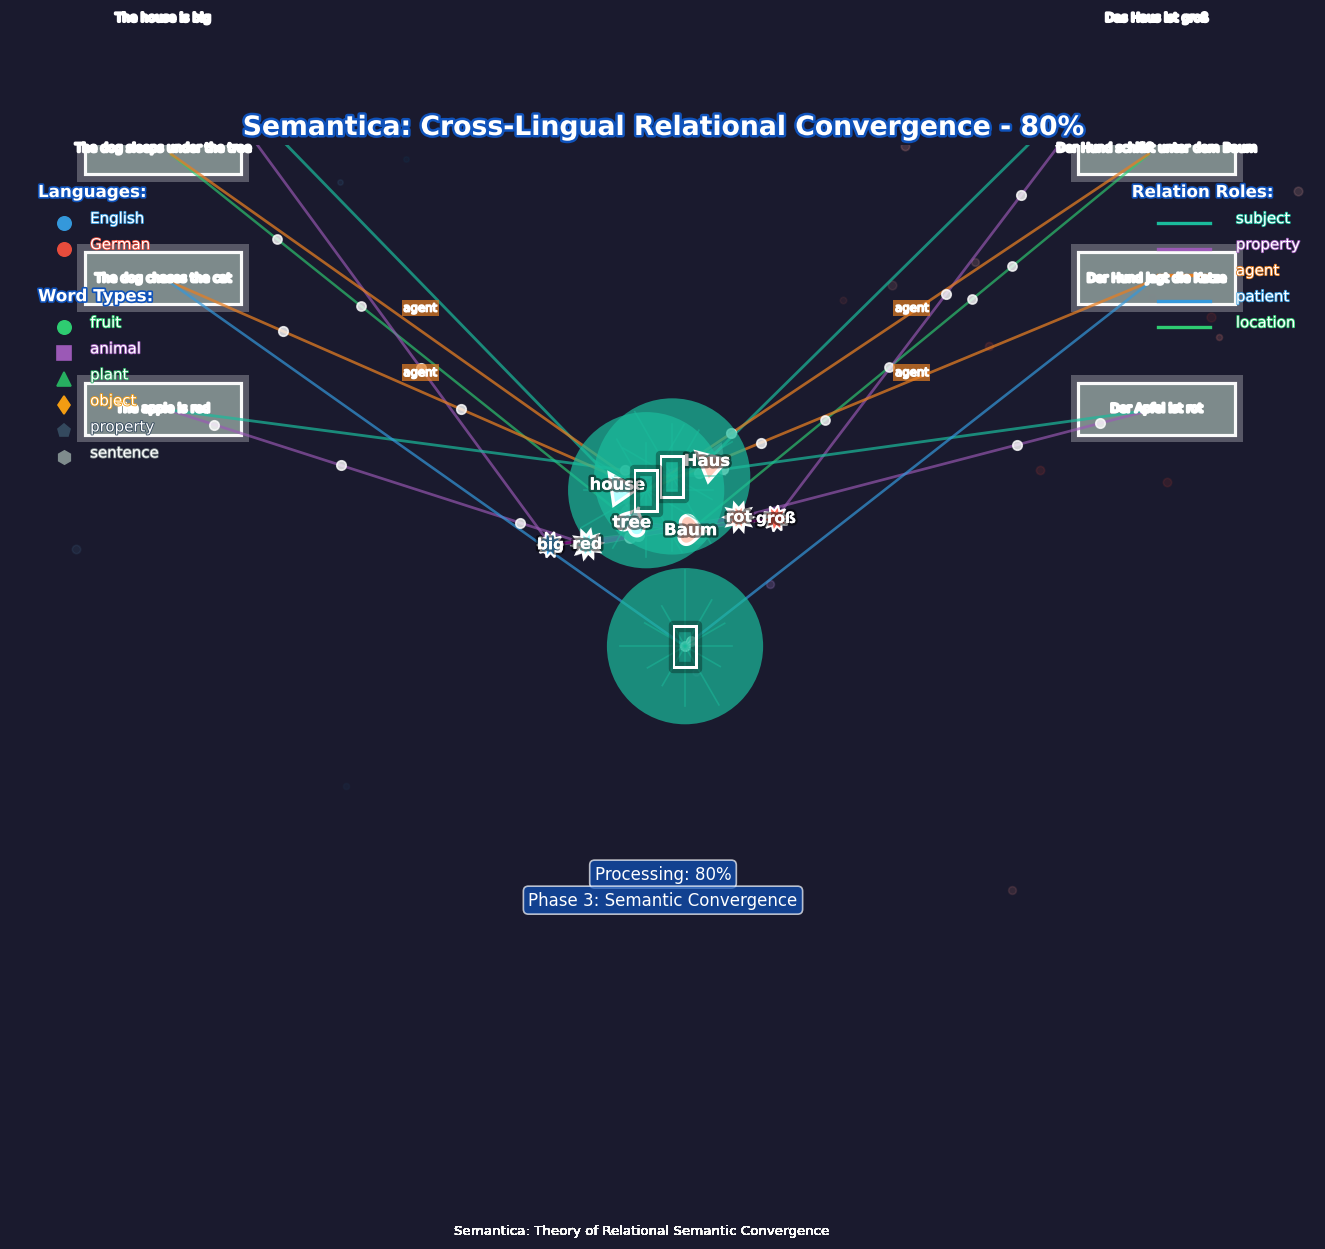

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from matplotlib.patches import FancyArrowPatch, Polygon, PathPatch
from matplotlib.path import Path
import random
from IPython.display import HTML
import io
import base64
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance, ImageOps
import os
import time
from tqdm import tqdm
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap, to_rgba
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
import colorsys

# Set up the output directory structure
curr_dir = os.getcwd()
output_data_path = os.path.join(curr_dir + r"\..", "Data", "Output")
os.makedirs(output_data_path, exist_ok=True)

# Define our word pairs (English-German)
word_pairs = [
    ('apple', 'Apfel'),
    ('dog', 'Hund'),
    ('cat', 'Katze'),
    ('tree', 'Baum'),
    ('house', 'Haus')
]

# Define sentence relations
# Format: (sentence_id, language, sentence, [(word, role)])
sentences = [
    # Apple sentences
    (1, 'english', "The apple is red", [('apple', 'subject'), ('red', 'property')]),
    (1, 'german', "Der Apfel ist rot", [('Apfel', 'subject'), ('rot', 'property')]),
    
    # Animal sentences
    (2, 'english', "The dog chases the cat", [('dog', 'agent'), ('cat', 'patient')]),
    (2, 'german', "Der Hund jagt die Katze", [('Hund', 'agent'), ('Katze', 'patient')]),
    
    # Location sentences
    (3, 'english', "The dog sleeps under the tree", [('dog', 'agent'), ('tree', 'location')]),
    (3, 'german', "Der Hund schläft unter dem Baum", [('Hund', 'agent'), ('Baum', 'location')]),
    
    # Property sentences
    (4, 'english', "The house is big", [('house', 'subject'), ('big', 'property')]),
    (4, 'german', "Das Haus ist groß", [('Haus', 'subject'), ('groß', 'property')]),
]

# Additional words from sentences
additional_words = {
    'red': {'type': 'property', 'emoji': '🔴'},
    'rot': {'type': 'property', 'emoji': '🔴'},
    'big': {'type': 'property', 'emoji': '📏'},
    'groß': {'type': 'property', 'emoji': '📏'},
}

# Types of words (for different shapes)
word_types = {
    'apple': 'fruit',
    'Apfel': 'fruit',
    'dog': 'animal',
    'Hund': 'animal',
    'cat': 'animal',
    'Katze': 'animal',
    'tree': 'plant',
    'Baum': 'plant',
    'house': 'object',
    'Haus': 'object',
    'red': 'property',
    'rot': 'property',
    'big': 'property',
    'groß': 'property',
}

# Emoji mappings
emoji_map = {
    'apple': '🍎',
    'dog': '🐕',
    'cat': '🐈',
    'tree': '🌳',
    'house': '🏠',
    'red': '🔴',
    'big': '📏',
}

# Create custom color gradients for each language
# Blue gradient for English
english_cmap = LinearSegmentedColormap.from_list('english_gradient',
                                                 ['#0a4c75', '#3498db', '#85c1e9'])

# Red gradient for German
german_cmap = LinearSegmentedColormap.from_list('german_gradient',
                                               ['#7d1a0c', '#e74c3c', '#f5b7b1'])

# Main colors based on language
language_colors = {
    'english': '#3498db',  # Blue
    'german': '#e74c3c'    # Red
}

# Custom color schemes for visualization
type_colors = {
    'fruit': '#2ecc71',    # Green
    'animal': '#9b59b6',   # Purple
    'plant': '#27ae60',    # Dark Green
    'object': '#f39c12',   # Orange
    'property': '#34495e', # Dark Gray
    'sentence': '#7f8c8d'  # Light Gray
}

# Colors based on role in sentence
role_colors = {
    'subject': '#1abc9c',  # Teal
    'property': '#9b59b6', # Purple
    'agent': '#e67e22',    # Orange
    'patient': '#3498db',  # Blue
    'location': '#2ecc71'  # Green
}

# Define custom node shapes
def custom_node_shape(node_type, size=1.0):
    """Generate custom node shapes based on word type"""
    # Base shapes with more visual interest
    if node_type == 'fruit':
        # Apple shape - circle with stem
        r = 0.5 * size
        theta = np.linspace(0, 2*np.pi, 30)
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        # Add stem
        x = np.append(x, [0, 0.1*size, 0.2*size])
        y = np.append(y, [r, r+0.2*size, r+0.1*size])
        return x, y
    
    elif node_type == 'animal':
        # Paw print shape
        r = 0.3 * size
        points = []
        # Main pad
        for theta in np.linspace(0, 2*np.pi, 20):
            points.append((r * 1.2 * np.cos(theta), r * np.sin(theta) - 0.1*size))
        # Toes
        for i, angle in enumerate([0, np.pi/6, np.pi/3, np.pi/2]):
            cx = r * np.cos(angle)
            cy = r * np.sin(angle) + 0.3*size
            for theta in np.linspace(0, 2*np.pi, 10):
                points.append((cx + r*0.5*np.cos(theta), cy + r*0.5*np.sin(theta)))
        
        points = np.array(points)
        return points[:, 0], points[:, 1]
    
    elif node_type == 'plant':
        # Leaf shape
        t = np.linspace(0, 2*np.pi, 100)
        x = 16 * np.sin(t)**3
        y = 13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t)
        # Scale and center
        x = x / 32 * size
        y = y / 32 * size
        return x, y
    
    elif node_type == 'object':
        # House shape
        x = np.array([-0.5, 0, 0.5, 0.5, -0.5, -0.5]) * size
        y = np.array([-0.5, 0.5, -0.5, -0.5, -0.5, -0.5]) * size
        return x, y
    
    elif node_type == 'property':
        # Starburst shape
        n_points = 10
        inner_radius = 0.3 * size
        outer_radius = 0.5 * size
        angles = np.linspace(0, 2*np.pi, n_points, endpoint=False)
        
        xs = []
        ys = []
        for i in range(n_points):
            # Outer point
            xs.append(outer_radius * np.cos(angles[i]))
            ys.append(outer_radius * np.sin(angles[i]))
            
            # Inner point
            xs.append(inner_radius * np.cos(angles[i] + np.pi/n_points))
            ys.append(inner_radius * np.sin(angles[i] + np.pi/n_points))
        
        return np.array(xs), np.array(ys)
    
    else:  # default or 'sentence'
        # Rounded rectangle
        x = np.array([-0.6, -0.6, 0.6, 0.6, -0.6]) * size
        y = np.array([-0.3, 0.3, 0.3, -0.3, -0.3]) * size
        return x, y

# Create initial graph
def create_initial_graph():
    print("Creating initial semantic graph structure...")
    G = nx.Graph()
    
    # Add nodes for words
    for en, de in word_pairs:
        # English words
        G.add_node(en, 
                  lang='english',
                  type=word_types[en],
                  emoji=emoji_map[en],
                  color=language_colors['english'],
                  position=np.array([-1.5 + random.uniform(-0.1, 0.1), random.uniform(-0.8, 0.8)]),
                  merged=False,
                  size=300,
                  highlight=0.0,
                  rotation=random.uniform(0, 360),
                  z_position=0.0)
        
        # German words
        G.add_node(de, 
                  lang='german',
                  type=word_types[de],
                  emoji=emoji_map[en],  # Use English word for emoji mapping
                  color=language_colors['german'],
                  position=np.array([1.5 + random.uniform(-0.1, 0.1), random.uniform(-0.8, 0.8)]),
                  merged=False,
                  size=300,
                  highlight=0.0,
                  rotation=random.uniform(0, 360),
                  z_position=0.0)
    
    # Add additional words from sentences
    for word, info in additional_words.items():
        if word not in G:
            lang = 'english' if word in ['red', 'big'] else 'german'
            emoji_key = word if word in emoji_map else 'red' if word in ['rot'] else 'big'
            
            G.add_node(word,
                      lang=lang,
                      type=info['type'],
                      emoji=info['emoji'],
                      color=language_colors[lang],
                      position=np.array([-1.5 if lang == 'english' else 1.5, random.uniform(-0.8, 0.8)]),
                      merged=False,
                      size=300,
                      highlight=0.0,
                      rotation=random.uniform(0, 360),
                      z_position=0.0)
    
    # Add sentence nodes
    sentence_positions = {}
    for sent_id, lang, text, roles in sentences:
        node_id = f"sentence_{sent_id}_{lang}"
        x_pos = -1.0 if lang == 'english' else 1.0
        y_pos = 0.5 * sent_id
        
        sentence_positions[(sent_id, lang)] = np.array([x_pos, y_pos])
        
        G.add_node(node_id,
                  lang=lang,
                  type='sentence',
                  text=text,
                  color=type_colors['sentence'],
                  position=np.array([x_pos, y_pos]),
                  roles=roles,
                  merged=False,
                  size=400,
                  highlight=0.0,
                  rotation=0,
                  z_position=-0.1)  # Place sentences slightly behind
    
    print(f"Added {len(G.nodes)} nodes to the graph")
    return G, sentence_positions

# Add pulsating effect to node
def pulsate(t, base_size=1.0, amplitude=0.2, frequency=2.0):
    return base_size + amplitude * np.sin(frequency * t)

# Add edges gradually and update graph for each frame
def update_graph(G, sentence_positions, frame, total_frames):
    progress = frame / total_frames
    
    # Background frequency for global waves of activity
    global_wave = np.sin(progress * 10 * np.pi) * 0.5 + 0.5
    
    # Phase 1: Add word-sentence relations (0-25% of frames)
    if progress <= 0.25:
        phase_progress = progress / 0.25
        
        # Process each sentence
        for sent_id, lang, text, roles in sentences:
            node_id = f"sentence_{sent_id}_{lang}"
            
            # Highlight sentence node if it's being connected
            if 0.05 < phase_progress < 0.95:
                G.nodes[node_id]['highlight'] = min(1.0, G.nodes[node_id].get('highlight', 0) + 0.05)
            else:
                G.nodes[node_id]['highlight'] = max(0.0, G.nodes[node_id].get('highlight', 0) - 0.05)
            
            # Add edges from words to sentences
            for word, role in roles:
                if word in G.nodes:
                    # Determine if we should add this edge based on progress
                    role_idx = ['subject', 'property', 'agent', 'patient', 'location'].index(role) if role in ['subject', 'property', 'agent', 'patient', 'location'] else 0
                    threshold = 0.1 + (role_idx * 0.03)
                    
                    # Highlight word when it's being connected
                    if abs(phase_progress - threshold) < 0.1:
                        G.nodes[word]['highlight'] = min(1.0, G.nodes[word].get('highlight', 0) + 0.1)
                        # Add some vertical bounce
                        G.nodes[word]['z_position'] = 0.1 * np.sin(phase_progress * 20 * np.pi)
                    else:
                        G.nodes[word]['highlight'] = max(0.0, G.nodes[word].get('highlight', 0) - 0.05)
                        G.nodes[word]['z_position'] = max(0.0, G.nodes[word].get('z_position', 0) - 0.01)
                    
                    if phase_progress > threshold:
                        if not G.has_edge(node_id, word):
                            # Add edge with role information
                            edge_strength = min(1.0, (phase_progress - threshold) * 5)
                            G.add_edge(node_id, word, 
                                      role=role, 
                                      weight=edge_strength, 
                                      alpha=edge_strength,
                                      color=role_colors.get(role, 'gray'),
                                      flow=0.0,
                                      particles=[])
                        
                        # If edge exists, increase its strength
                        elif G.has_edge(node_id, word):
                            G[node_id][word]['weight'] = min(2.0, G[node_id][word]['weight'] + 0.05)
                            G[node_id][word]['alpha'] = min(1.0, G[node_id][word]['alpha'] + 0.02)
                            
                            # Add flow effect to edges
                            G[node_id][word]['flow'] = (G[node_id][word]['flow'] + 0.05) % 1.0
                            
                            # Generate particles along the edge for animation
                            if random.random() < 0.1:
                                G[node_id][word]['particles'].append(random.random())
                            
                            # Move existing particles along the edge
                            new_particles = []
                            for p in G[node_id][word]['particles']:
                                p += 0.03
                                if p < 1.0:
                                    new_particles.append(p)
                            G[node_id][word]['particles'] = new_particles
    
    # Phase 2: Add cross-language word relations (25-50% of frames)
    if 0.25 < progress <= 0.5:
        phase_progress = (progress - 0.25) / 0.25
        
        # Add edges between equivalent words
        for i, (en, de) in enumerate(word_pairs):
            # Skip if already merged
            if G.nodes[en].get('merged') or G.nodes[de].get('merged'):
                continue
                
            # Calculate threshold based on word pair index
            threshold = i / len(word_pairs) * 0.8
            
            # Highlight words when they're about to be connected
            if abs(phase_progress - threshold) < 0.1:
                G.nodes[en]['highlight'] = min(1.0, G.nodes[en].get('highlight', 0) + 0.1)
                G.nodes[de]['highlight'] = min(1.0, G.nodes[de].get('highlight', 0) + 0.1)
                
                # Add anticipatory rotation to nodes
                G.nodes[en]['rotation'] = (G.nodes[en]['rotation'] + 2) % 360
                G.nodes[de]['rotation'] = (G.nodes[de]['rotation'] + 2) % 360
            else:
                G.nodes[en]['highlight'] = max(0.0, G.nodes[en].get('highlight', 0) - 0.05)
                G.nodes[de]['highlight'] = max(0.0, G.nodes[de].get('highlight', 0) - 0.05)
            
            # Add the edge if we've progressed past the threshold for this pair
            if phase_progress > threshold:
                if not G.has_edge(en, de):
                    # Add the edge with increasing opacity and width
                    edge_strength = min(1.0, (phase_progress - threshold) * 5)
                    G.add_edge(en, de, 
                              weight=edge_strength, 
                              alpha=edge_strength, 
                              color='purple',
                              flow=0.0,
                              particles=[],
                              electric=0.0)
                else:
                    # Increase existing edge weight
                    current_weight = G[en][de]['weight']
                    G[en][de]['weight'] = min(3.0, current_weight + 0.1)
                    G[en][de]['alpha'] = min(1.0, G[en][de]['alpha'] + 0.05)
                    
                    # Add electric effect to cross-language edges
                    G[en][de]['electric'] = (G[en][de]['electric'] + 0.05) % 1.0
                    
                    # Generate particles along the edge for animation
                    if random.random() < 0.2:
                        G[en][de]['particles'].append(random.random())
                    
                    # Move existing particles along the edge
                    new_particles = []
                    for p in G[en][de]['particles']:
                        p += 0.04
                        if p < 1.0:
                            new_particles.append(p)
                    G[en][de]['particles'] = new_particles
        
        # Add edges between additional word pairs
        additional_pairs = [('red', 'rot'), ('big', 'groß')]
        for i, (en, de) in enumerate(additional_pairs):
            if en in G.nodes and de in G.nodes:
                # Skip if already merged
                if G.nodes[en].get('merged') or G.nodes[de].get('merged'):
                    continue
                    
                # Calculate threshold
                threshold = 0.4 + (i / len(additional_pairs) * 0.4)
                
                # Highlight words when they're about to be connected
                if abs(phase_progress - threshold) < 0.1:
                    G.nodes[en]['highlight'] = min(1.0, G.nodes[en].get('highlight', 0) + 0.1)
                    G.nodes[de]['highlight'] = min(1.0, G.nodes[de].get('highlight', 0) + 0.1)
                else:
                    G.nodes[en]['highlight'] = max(0.0, G.nodes[en].get('highlight', 0) - 0.05)
                    G.nodes[de]['highlight'] = max(0.0, G.nodes[de].get('highlight', 0) - 0.05)
                
                # Add edge if we've progressed past threshold
                if phase_progress > threshold:
                    if not G.has_edge(en, de):
                        edge_strength = min(1.0, (phase_progress - threshold) * 5)
                        G.add_edge(en, de, 
                                  weight=edge_strength, 
                                  alpha=edge_strength, 
                                  color='purple',
                                  flow=0.0,
                                  particles=[],
                                  electric=0.0)
                    else:
                        G[en][de]['weight'] = min(3.0, G[en][de]['weight'] + 0.1)
                        G[en][de]['alpha'] = min(1.0, G[en][de]['alpha'] + 0.05)
                        
                        # Add electric effect to cross-language edges
                        G[en][de]['electric'] = (G[en][de]['electric'] + 0.05) % 1.0
                        
                        # Generate particles along the edge for animation
                        if random.random() < 0.2:
                            G[en][de]['particles'].append(random.random())
                        
                        # Move existing particles
                        new_particles = []
                        for p in G[en][de]['particles']:
                            p += 0.04
                            if p < 1.0:
                                new_particles.append(p)
                        G[en][de]['particles'] = new_particles
    
    # Phase 3: Move nodes toward their equivalents (50-80% of frames)
    if 0.5 < progress <= 0.8:
        phase_progress = (progress - 0.5) / 0.3
        
        # Calculate global wave for synchronized movement
        wave_effect = np.sin(phase_progress * 5 * np.pi) * 0.5 + 0.5
        
        # Move word nodes toward their equivalents
        for i, (en, de) in enumerate(word_pairs + [('red', 'rot'), ('big', 'groß')]):
            if en in G.nodes and de in G.nodes:
                # Skip if already merged
                if G.nodes[en].get('merged') or G.nodes[de].get('merged'):
                    continue
                    
                # Calculate threshold
                threshold = i / (len(word_pairs) + 2) * 0.7
                
                # Move nodes if we've progressed past threshold
                if phase_progress > threshold and G.has_edge(en, de):
                    # Calculate target position (middle point with some variance)
                    en_pos = G.nodes[en]['position']
                    de_pos = G.nodes[de]['position']
                    
                    # Move gradually toward center
                    midpoint = (en_pos + de_pos) / 2
                    
                    # Speed up as we get closer to the end
                    move_factor = min(0.1, (phase_progress - threshold) * 0.3 * (1 + wave_effect * 0.5))
                    
                    # Add oscillation to the movement
                    oscillation = 0.03 * np.sin(phase_progress * 20 * np.pi)
                    
                    G.nodes[en]['position'] = en_pos + (midpoint - en_pos) * move_factor + np.array([oscillation, oscillation])
                    G.nodes[de]['position'] = de_pos + (midpoint - de_pos) * move_factor + np.array([-oscillation, oscillation])
                    
                    # Change rotation as nodes approach each other
                    G.nodes[en]['rotation'] = (G.nodes[en]['rotation'] + 1) % 360
                    G.nodes[de]['rotation'] = (G.nodes[de]['rotation'] + 1) % 360
                    
                    # Increase z_position as nodes approach merging point
                    approach_factor = 1.0 - np.linalg.norm(G.nodes[en]['position'] - G.nodes[de]['position'])
                    G.nodes[en]['z_position'] = max(0.0, approach_factor * 0.3)
                    G.nodes[de]['z_position'] = max(0.0, approach_factor * 0.3)
                    
                    # Enhance highlight as nodes approach
                    G.nodes[en]['highlight'] = min(1.0, approach_factor * 2)
                    G.nodes[de]['highlight'] = min(1.0, approach_factor * 2)
                    
                    # Merge nodes if they're close enough
                    if np.linalg.norm(G.nodes[en]['position'] - G.nodes[de]['position']) < 0.2 and phase_progress > 0.9:
                        # Mark these nodes as merged
                        G.nodes[en]['merged'] = True
                        G.nodes[de]['merged'] = True
                        
                        # Visually indicate they're merged by making them small and transparent
                        G.nodes[en]['size'] = 0
                        G.nodes[de]['size'] = 0
                        G.nodes[en]['alpha'] = 0
                        G.nodes[de]['alpha'] = 0
                        
                        # Create merged emoji node
                        emoji = emoji_map.get(en, '❓')
                        merged_id = f"merged_{en}_{de}"
                        
                        G.add_node(merged_id,
                                  type='merged',
                                  emoji=emoji,
                                  position=midpoint,
                                  size=500,
                                  alpha=1.0,
                                  highlight=1.0,
                                  color='#1abc9c',  # Teal color for merged nodes
                                  rotation=0,
                                  z_position=0.5,  # Pop up slightly
                                  scale=1.0,
                                  merged_from=[en, de])
                        
                        # Copy all connections from original nodes to merged node
                        for source, target in list(G.edges()):
                            if source == en or source == de:
                                other = target
                                # Skip the edge that connected the two merged nodes
                                if other == en or other == de:
                                    continue
                                    
                                # Get edge data
                                if source == en:
                                    edge_data = G.get_edge_data(en, other).copy()
                                else:
                                    edge_data = G.get_edge_data(de, other).copy()
                                
                                # Add edge from merged node to other
                                G.add_edge(merged_id, other, **edge_data)
                                
                            elif target == en or target == de:
                                other = source
                                # Skip the edge that connected the two merged nodes
                                if other == en or other == de:
                                    continue
                                    
                                # Get edge data
                                if target == en:
                                    edge_data = G.get_edge_data(other, en).copy()
                                else:
                                    edge_data = G.get_edge_data(other, de).copy()
                                
                                # Add edge from other to merged node
                                G.add_edge(other, merged_id, **edge_data)
        
        # Move sentence nodes as well based on progress
        for sent_id, lang, text, roles in sentences:
            node_id = f"sentence_{sent_id}_{lang}"
            if node_id in G.nodes:
                # Move English sentences left, German sentences right
                x_target = -2.0 if lang == 'english' else 2.0
                y_target = sentence_positions[(sent_id, lang)][1]
                
                current_pos = G.nodes[node_id]['position']
                target_pos = np.array([x_target, y_target])
                
                # Calculate move factor based on progress
                move_factor = phase_progress * 0.1
                
                # Add slight oscillation to sentence movement
                oscillation = 0.01 * np.sin(phase_progress * 10 * np.pi) * np.array([1, 1])
                
                # Update position
                G.nodes[node_id]['position'] = current_pos + (target_pos - current_pos) * move_factor + oscillation
    
    # Phase 4: Final stabilization and visual flourish (80-100% of frames)
    if progress > 0.8:
        # Enhance merged nodes
        phase_progress = (progress - 0.8) / 0.2
        pulse = 1.0 + 0.3 * np.sin(phase_progress * 10 * np.pi)
        
        # Process all merged nodes
        for node in list(G.nodes()):
            if node.startswith('merged_'):
                # Pulsating size effect
                G.nodes[node]['size'] = 500 * pulse
                
                # Color cycling effect
                hue = (phase_progress * 2) % 1.0  # Cycle through hues
                r, g, b = colorsys.hsv_to_rgb(hue, 0.7, 0.9)
                G.nodes[node]['color'] = (r, g, b, 1.0)
                
                # Z-position bobbing
                G.nodes[node]['z_position'] = 0.5 + 0.2 * np.sin(phase_progress * 15 * np.pi)
                
                # Add glow effect by increasing highlight
                G.nodes[node]['highlight'] = 0.5 + 0.5 * np.sin(phase_progress * 8 * np.pi)
                
                # Connection energy flowing into merged node
                for neighbor in G.neighbors(node):
                    if G.has_edge(node, neighbor):
                        # Increase particle generation on edges connected to merged nodes
                        if random.random() < 0.3:
                            G[node][neighbor]['particles'].append(random.random())
                        
                        # Faster particle movement
                        new_particles = []
                        for p in G[node][neighbor]['particles']:
                            p += 0.06
                            if p < 1.0:
                                new_particles.append(p)
                        G[node][neighbor]['particles'] = new_particles
                        
                        # Electric effect intensifies on these edges
                        G[node][neighbor]['electric'] = (G[node][neighbor]['electric'] + 0.08) % 1.0
        
        # Add final graph-wide energy wave
        wave_intensity = np.sin(phase_progress * 20 * np.pi) * 0.5 + 0.5
        
        # Add graph-wide energy pulse that ripples outward from merged nodes
        for node in G.nodes():
            if not node.startswith('merged_'):
                # Skip merged source nodes
                if G.nodes[node].get('merged', False):
                    continue
                
                # Find closest merged node
                min_dist = float('inf')
                for merged_node in [n for n in G.nodes() if n.startswith('merged_')]:
                    dist = np.linalg.norm(G.nodes[node]['position'] - G.nodes[merged_node]['position'])
                    min_dist = min(min_dist, dist)
                
                # Apply ripple effect based on distance
                ripple_factor = np.sin((phase_progress * 15 - min_dist * 2) * np.pi) * 0.5 + 0.5
                G.nodes[node]['highlight'] = max(G.nodes[node].get('highlight', 0), ripple_factor * wave_intensity * 0.7)
    
    return G

# Draw the graph with advanced visual effects
def draw_graph(G, ax, frame, total_frames):
    ax.clear()
    
    # Set up plot with dark background for visual impact
    ax.set_facecolor('#1a1a2e')  # Dark blue background
    fig = plt.gcf()
    fig.set_facecolor('#1a1a2e')
    
    # Set up plot dimensions
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add title with glowing effect
    percentage = int((frame / total_frames) * 100)
    title_text = f"Semantica: Cross-Lingual Relational Convergence - {percentage}%"
    title = ax.set_title(title_text, fontsize=16, color='white', fontweight='bold')
    title.set_path_effects([path_effects.Stroke(linewidth=3, foreground='#0f52ba'),
                           path_effects.Normal()])
    
    # Draw legend with enhanced styling
    # Language Legend
    legend_text = ax.text(-2.4, 1.3, "Languages:", fontsize=10, fontweight='bold', color='white')
    legend_text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='#0f52ba')])
    
    ax.plot(-2.3, 1.2, 'o', color=language_colors['english'], markersize=8)
    eng_text = ax.text(-2.2, 1.2, "English", fontsize=9, color='white')
    eng_text.set_path_effects([path_effects.withStroke(linewidth=1, foreground='#3498db')])
    
    ax.plot(-2.3, 1.1, 'o', color=language_colors['german'], markersize=8)
    ger_text = ax.text(-2.2, 1.1, "German", fontsize=9, color='white')
    ger_text.set_path_effects([path_effects.withStroke(linewidth=1, foreground='#e74c3c')])
    
    # Word Type Legend
    type_text = ax.text(-2.4, 0.9, "Word Types:", fontsize=10, fontweight='bold', color='white')
    type_text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='#0f52ba')])
    
    shapes = {'fruit': 'o', 'animal': 's', 'plant': '^', 'object': 'd', 'property': 'p', 'sentence': 'h'}
    y_pos = 0.8
    for type_name, shape in shapes.items():
        ax.plot(-2.3, y_pos, shape, color=type_colors[type_name], markersize=8)
        type_label = ax.text(-2.2, y_pos, type_name, fontsize=9, color='white')
        type_label.set_path_effects([path_effects.withStroke(linewidth=1, foreground=type_colors[type_name])])
        y_pos -= 0.1
    
    # Relationship Role Legend
    role_text = ax.text(1.8, 1.3, "Relation Roles:", fontsize=10, fontweight='bold', color='white')
    role_text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='#0f52ba')])
    
    y_pos = 1.2
    for role, color in role_colors.items():
        ax.plot([1.9, 2.1], [y_pos, y_pos], '-', color=color, linewidth=2)
        role_label = ax.text(2.2, y_pos, role, fontsize=9, color='white')
        role_label.set_path_effects([path_effects.withStroke(linewidth=1, foreground=color)])
        y_pos -= 0.1
    
    # Progress indicator
    progress = frame / total_frames
    ax.text(0, -1.3, f"Processing: {percentage}%", 
           fontsize=10, ha='center', va='center', color='white',
           bbox=dict(facecolor='#0f52ba', alpha=0.7, boxstyle="round,pad=0.3"))
    
    # Phase indicator
    phase_text = ""
    if progress <= 0.25:
        phase_text = "Phase 1: Establishing Intra-Language Relations"
    elif progress <= 0.5:
        phase_text = "Phase 2: Creating Cross-Language Equivalences"
    elif progress <= 0.8:
        phase_text = "Phase 3: Semantic Convergence"
    else:
        phase_text = "Phase 4: Relational Stabilization"
    
    phase_indicator = ax.text(0, -1.4, phase_text,
                             fontsize=10, ha='center', va='center', color='white',
                             bbox=dict(facecolor='#0f52ba', alpha=0.7, boxstyle="round,pad=0.3"))
    
    # Draw animated background elements - subtle particle system
    if progress > 0.5:
        # Add more particles as we progress
        num_particles = int(30 * (progress - 0.5) * 2)
        for i in range(num_particles):
            x = random.uniform(-2.5, 2.5)
            y = random.uniform(-1.5, 1.5)
            size = random.uniform(10, 30)
            alpha = random.uniform(0.05, 0.2)
            
            # Generate color based on position (left=blue, right=red, middle=purple)
            if x < -0.5:
                # English side - blue hues
                color = english_cmap(random.random())
            elif x > 0.5:
                # German side - red hues
                color = german_cmap(random.random())
            else:
                # Convergence zone - purple hues
                r = 0.5 + random.random() * 0.5
                g = 0.3 + random.random() * 0.3
                b = 0.8 + random.random() * 0.2
                color = (r, g, b, alpha)
            
            # Draw particle
            ax.scatter(x, y, s=size, color=color, alpha=alpha, edgecolors=None, zorder=1)
    
    # Draw edges with advanced visual effects
    for u, v, data in G.edges(data=True):
        # Skip edges connected to merged nodes (original words that merged)
        if (G.nodes[u].get('merged', False) and not u.startswith('merged_')) or \
           (G.nodes[v].get('merged', False) and not v.startswith('merged_')):
            continue
            
        pos1 = G.nodes[u]['position']
        pos2 = G.nodes[v]['position']
        
        # Adjust positions based on z-position
        z1 = G.nodes[u].get('z_position', 0)
        z2 = G.nodes[v].get('z_position', 0)
        
        # Simple perspective effect
        perspective_factor = 0.1
        pos1_adj = pos1 * (1 + z1 * perspective_factor)
        pos2_adj = pos2 * (1 + z2 * perspective_factor)
        
        # Draw edge with appropriate thickness and transparency
        weight = data.get('weight', 1.0)
        alpha = data.get('alpha', 0.5)
        color = data.get('color', 'gray')
        
        # Apply flow or electric effect
        flow = data.get('flow', 0.0)
        electric = data.get('electric', 0.0)
        
        # Draw main edge
        if electric > 0:
            # Electric effect for cross-language connections
            # Create a zigzag pattern that animates
            segment_points = 10
            t_vals = np.linspace(0, 1, segment_points)
            
            # Create zigzag between the points
            zx = []
            zy = []
            
            for i, t in enumerate(t_vals):
                # Base point along straight line
                x = pos1_adj[0] + t * (pos2_adj[0] - pos1_adj[0])
                y = pos1_adj[1] + t * (pos2_adj[1] - pos1_adj[1])
                
                # Add zigzag displacement
                if i > 0 and i < segment_points - 1:
                    # Calculate perpendicular direction
                    dx = pos2_adj[0] - pos1_adj[0]
                    dy = pos2_adj[1] - pos1_adj[1]
                    length = np.sqrt(dx*dx + dy*dy)
                    
                    # Perpendicular unit vector
                    if length > 0:
                        px = -dy / length
                        py = dx / length
                        
                        # Calculate zigzag displacement
                        zigzag_amplitude = 0.05 * weight
                        zigzag = zigzag_amplitude * np.sin((i + electric * 20) * np.pi)
                        
                        # Apply displacement
                        x += px * zigzag
                        y += py * zigzag
                
                zx.append(x)
                zy.append(y)
            
            # Draw the zigzag path
            ax.plot(zx, zy, '-', color=color, linewidth=weight, alpha=alpha, zorder=2)
            
            # Add glowing effect
            glow = ax.plot(zx, zy, '-', color='white', linewidth=weight+1, alpha=alpha*0.3, zorder=1)
        else:
            # Regular flow effect for standard edges
            arrow = FancyArrowPatch(
                posA=pos1_adj, posB=pos2_adj,
                arrowstyle='-',
                color=color,
                linewidth=weight,
                alpha=alpha,
                mutation_scale=10,
                zorder=2
            )
            ax.add_patch(arrow)
        
        # Draw particles along the edge for animation
        for p in data.get('particles', []):
            # Interpolate position along the edge
            px = pos1_adj[0] + p * (pos2_adj[0] - pos1_adj[0])
            py = pos1_adj[1] + p * (pos2_adj[1] - pos1_adj[1])
            
            # Draw particle
            ax.scatter(px, py, s=20*weight, color='white', alpha=0.8, zorder=3)
        
        # Add role label if it's a sentence-word edge
        if (u.startswith('sentence_') or v.startswith('sentence_')) and 'role' in data:
            # Calculate midpoint
            mid_x = (pos1_adj[0] + pos2_adj[0]) / 2
            mid_y = (pos1_adj[1] + pos2_adj[1]) / 2
            
            # Add small offset to avoid overlap
            offset = 0.05
            label_pos = (mid_x + offset, mid_y + offset)
            
            # Add role label
            if alpha > 0.7:  # Only show labels for strong edges
                role_label = ax.text(label_pos[0], label_pos[1], data['role'], fontsize=7, 
                       ha='center', va='center', color='white',
                       bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=1))
                role_label.set_path_effects([path_effects.withStroke(linewidth=1, foreground='white')])
    
    # Draw sentence nodes first (so they are in back)
    for node, data in G.nodes(data=True):
        if node.startswith('sentence_') and not data.get('merged', False):
            pos = data['position']
            highlight = data.get('highlight', 0.0)
            
            # Draw the node as a rounded rectangle with glow effect
            rect = plt.Rectangle(
                (pos[0] - 0.3, pos[1] - 0.1),
                0.6, 0.2,
                facecolor=data['color'],
                alpha=0.7 + highlight * 0.3,  # Increase alpha with highlight
                edgecolor='white',
                linewidth=1 + highlight,  # Thicker border when highlighted
                zorder=1
            )
            ax.add_patch(rect)
            
            # Add glow effect when highlighted
            if highlight > 0.3:
                glow = plt.Rectangle(
                    (pos[0] - 0.33, pos[1] - 0.13),
                    0.66, 0.26,
                    facecolor='white',
                    alpha=highlight * 0.3,
                    edgecolor=None,
                    zorder=0
                )
                ax.add_patch(glow)
            
            # Add the sentence text
            lang = data['lang']
            text = data['text']
            text_color = 'white'
            
            sentence_text = ax.text(pos[0], pos[1], text, fontsize=7, ha='center', va='center', 
                   color=text_color, zorder=2,
                   bbox=dict(facecolor=data['color'], alpha=0.0, pad=1))
            
            # Add subtle glow to text when highlighted
            if highlight > 0.3:
                sentence_text.set_path_effects([path_effects.withStroke(linewidth=1+highlight, foreground='white')])
    
    # Draw word nodes with advanced styles
    for node, data in G.nodes(data=True):
        # Skip rendering merged original nodes
        if data.get('merged', False) and not node.startswith('merged_'):
            continue
            
        # Skip sentence nodes (already drawn)
        if node.startswith('sentence_'):
            continue
            
        pos = data['position']
        highlight = data.get('highlight', 0.0)
        z_pos = data.get('z_position', 0.0)
        
        # Apply perspective scaling based on z-position
        size_scale = 1 + z_pos * 0.5
        pos_scale = 1 + z_pos * 0.1
        
        # Adjust position with perspective
        pos_adj = pos * pos_scale
        
        # For merged nodes, draw the emoji with special effects
        if node.startswith('merged_'):
            emoji = data['emoji']
            size = data['size'] * size_scale
            
            # Draw a pulsating glow effect
            glow_radius = 0.2 * (1 + highlight * 0.5)
            glow = plt.Circle(
                pos_adj, glow_radius,
                facecolor=data['color'],
                alpha=0.4 + highlight * 0.3,
                edgecolor=None,
                zorder=3
            )
            ax.add_patch(glow)
            
            # Draw energy rays emanating from merged node
            if highlight > 0.3:
                ray_count = 12
                max_length = 0.3 * highlight
                for i in range(ray_count):
                    angle = (i / ray_count) * 2 * np.pi
                    # Randomize ray length
                    ray_length = max_length * (0.5 + 0.5 * random.random())
                    end_x = pos_adj[0] + np.cos(angle) * ray_length
                    end_y = pos_adj[1] + np.sin(angle) * ray_length
                    
                    # Draw ray
                    ray = ax.plot([pos_adj[0], end_x], [pos_adj[1], end_y], '-', 
                                 color=data['color'], alpha=highlight*0.5, linewidth=1, zorder=4)
            
            # Draw the emoji with shadow effect
            emoji_text = ax.text(pos_adj[0], pos_adj[1], emoji, 
                               fontsize=24 * size_scale, 
                               ha='center', va='center', zorder=5)
            
            # Create shadow/glow effect
            emoji_text.set_path_effects([
                path_effects.withStroke(linewidth=5, foreground='black', alpha=0.3),
                path_effects.Normal()
            ])
            
            continue
        
        # Regular word nodes with custom stylized shapes
        node_type = data['type']
        color = data['color']
        alpha = data.get('alpha', 1.0)
        size = data.get('size', 300) * size_scale
        rotation = data.get('rotation', 0)
        
        # Calculate color variation based on highlighting
        if highlight > 0:
            # Create color gradient from base color to white based on highlight intensity
            base_rgb = to_rgba(color)
            r = min(1.0, base_rgb[0] + highlight * 0.5)
            g = min(1.0, base_rgb[1] + highlight * 0.5)
            b = min(1.0, base_rgb[2] + highlight * 0.5)
            enhanced_color = (r, g, b, base_rgb[3])
        else:
            enhanced_color = color
        
        if size > 0:
            # Draw custom node shape
            x, y = custom_node_shape(node_type, size=0.1*size_scale)
            
            # Apply rotation if needed
            if rotation != 0:
                theta = np.radians(rotation)
                x_rot = x * np.cos(theta) - y * np.sin(theta)
                y_rot = x * np.sin(theta) + y * np.cos(theta)
                x, y = x_rot, y_rot
            
            # Create polygon for the node shape
            verts = np.column_stack([x + pos_adj[0], y + pos_adj[1]])
            node_poly = Polygon(verts, closed=True, facecolor=enhanced_color, 
                              alpha=alpha, edgecolor='white', linewidth=1 + highlight, zorder=4)
            ax.add_patch(node_poly)
            
            # Add glow effect when highlighted
            if highlight > 0.3:
                # Scale up the shape slightly for glow
                glow_scale = 1.2
                x_glow = x * glow_scale
                y_glow = y * glow_scale
                
                # Apply same rotation if needed
                if rotation != 0:
                    theta = np.radians(rotation)
                    x_rot = x_glow * np.cos(theta) - y_glow * np.sin(theta)
                    y_rot = x_glow * np.sin(theta) + y_glow * np.cos(theta)
                    x_glow, y_glow = x_rot, y_rot
                
                # Create glow polygon
                glow_verts = np.column_stack([x_glow + pos_adj[0], y_glow + pos_adj[1]])
                glow_poly = Polygon(glow_verts, closed=True, facecolor='white', 
                                  alpha=highlight * 0.3, edgecolor=None, zorder=3)
                ax.add_patch(glow_poly)
            
            # Label the node with enhanced text effect
            label_color = 'white'
            node_label = ax.text(pos_adj[0], pos_adj[1], node, fontsize=9*size_scale, 
                               ha='center', va='center', color=label_color, 
                               fontweight='bold', zorder=5)
            
            # Add text shadow effect
            node_label.set_path_effects([
                path_effects.withStroke(linewidth=3, foreground='black', alpha=0.5),
                path_effects.Normal()
            ])

# Create the animation function with enhanced post-processing
def create_semantica_animation():
    # Set up the output path
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    output_file = os.path.join(output_data_path, f"semantica_advanced_{timestamp}.gif")
    
    print(f"Animation will be saved to: {output_file}")
    print("Initializing visualization...")
    
    # Create figure with higher quality
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(14, 12), dpi=120)
    ax = fig.add_subplot(111)
    
    # Create initial graph
    G, sentence_positions = create_initial_graph()
    
    # Set up animation
    total_frames = 150  # Increased for smoother animation
    
    # Create list to store frames for GIF
    frames = []
    
    # Use tqdm for progress bar
    for frame in tqdm(range(total_frames + 1), desc="Generating visualization frames"):
        # Update graph based on frame
        G = update_graph(G, sentence_positions, frame, total_frames)
        
        # Draw the current state
        draw_graph(G, ax, frame, total_frames)
        
        # Add title watermark
        plt.figtext(0.5, 0.01, "Semantica: Theory of Relational Semantic Convergence", 
                   ha='center', color='white', alpha=0.3, fontsize=8)
        
        # Capture the frame
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120, facecolor='#1a1a2e')
        buf.seek(0)
        img = Image.open(buf)
        
        # Apply post-processing for enhanced visual quality
        # Add subtle bloom effect
        bloom = img.filter(ImageFilter.GaussianBlur(radius=2))
        bloom = ImageEnhance.Brightness(bloom).enhance(1.5)
        
        # Composite the original image with the bloom
        result = Image.composite(bloom, img, ImageEnhance.Brightness(img).enhance(0.7))
        
        # Apply color correction
        result = ImageEnhance.Contrast(result).enhance(1.2)
        result = ImageEnhance.Color(result).enhance(1.3)
        
        frames.append(result)
        
        # Print progress
        if frame % 30 == 0 and frame > 0:
            print(f"Processed {frame}/{total_frames} frames ({frame/total_frames*100:.1f}%)")
    
    # Save the gif with enhanced settings
    print(f"Saving animation to {output_file}...")
    frames[0].save(
        output_file,
        format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=80,  # Faster frame rate for smoother animation
        loop=0,       # Loop forever
        optimize=False  # Higher quality
    )
    print("Animation saved!")
    
    plt.close()
    return output_file

# Execute the function to create the animation
if __name__ == "__main__":
    print("Starting Semantica advanced visualization with enhanced visuals")
    print("This may take several minutes to process...")
    gif_path = create_semantica_animation()
    print(f"✨ Visualization masterpiece created at: {gif_path}")
    print("Process complete!")

# Phase 3

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from typing import List, Dict, Any, Tuple
import uuid
import random
from dataclasses import dataclass, field
import os

class SemanticaPrimitive:
    """
    Represents a semantic primitive with rich contextual metadata
    """
    def __init__(self, 
                 value: str, 
                 primitive_type: str = 'generic', 
                 language: str = 'universal',
                 embedding: np.ndarray = None):
        self.id = str(uuid.uuid4())
        self.value = value
        self.type = primitive_type
        self.language = language
        self.embedding = embedding if embedding is not None else np.random.rand(50)
        self.metadata = {}
        self.semantic_energy = 0.5  # New attribute to represent semantic potency

    def __repr__(self):
        return f"Primitive(value={self.value}, type={self.type}, lang={self.language})"

@dataclass
class SemanticRelation:
    """
    Represents a relation between primitives with validation and confidence
    """
    source: SemanticaPrimitive
    target: SemanticaPrimitive
    relation_type: str
    confidence: float = 0.0
    agent_validations: List[str] = field(default_factory=list)
    semantic_intensity: float = 0.0
    
    def validate(self, agent_id: str):
        """Track agent validations and update confidence"""
        if agent_id not in self.agent_validations:
            self.agent_validations.append(agent_id)
            self.confidence = min(1.0, self.confidence + 0.1)
            self.semantic_intensity = len(self.agent_validations) * 0.2

class SemanticAgent:
    """
    An agent that can propose, validate, and modify semantic relations
    """
    def __init__(self, agent_id: str, expertise: Dict[str, float] = None):
        self.id = agent_id
        self.expertise = expertise or {}
        self.memory_graph = nx.DiGraph()

    def propose_relation(self, 
                         source: SemanticaPrimitive, 
                         target: SemanticaPrimitive, 
                         relation_type: str) -> SemanticRelation:
        """Propose a semantic relation based on agent's expertise"""
        confidence = self.expertise.get(relation_type, 0.5)
        relation = SemanticRelation(source, target, relation_type, confidence)
        relation.validate(self.id)
        
        # Boost semantic energy of primitives
        source.semantic_energy += 0.1
        target.semantic_energy += 0.1
        
        return relation

class SemanticaGraph:
    """
    Central semantic graph that manages primitives, relations, and convergence
    """
    def __init__(self, output_dir: str = None):
        self.primitives = {}
        self.relations = []
        self.agents = {}
        self.convergence_graph = nx.DiGraph()
        self.output_dir = output_dir or os.path.join(os.getcwd(), 'output')
        os.makedirs(self.output_dir, exist_ok=True)

    def add_primitive(self, primitive: SemanticaPrimitive):
        """Add a new primitive to the semantic space"""
        self.primitives[primitive.id] = primitive
        return primitive

    def add_agent(self, agent: SemanticAgent):
        """Register a new semantic agent"""
        self.agents[agent.id] = agent

    def propose_relation(self, 
                         source_primitive: SemanticaPrimitive, 
                         target_primitive: SemanticaPrimitive, 
                         relation_type: str,
                         proposing_agent: SemanticAgent):
        """Propose and potentially validate a semantic relation"""
        relation = proposing_agent.propose_relation(
            source_primitive, 
            target_primitive, 
            relation_type
        )
        
        # Cross-validate with other agents
        for agent in self.agents.values():
            if agent.id != proposing_agent.id:
                # More nuanced validation logic
                validation_prob = 0.7 * (1 + agent.expertise.get(relation_type, 0.5))
                if random.random() < validation_prob:
                    relation.validate(agent.id)
        
        self.relations.append(relation)
        
        # Update convergence graph
        self.convergence_graph.add_edge(
            source_primitive.id, 
            target_primitive.id, 
            relation_type=relation_type,
            confidence=relation.confidence,
            semantic_intensity=relation.semantic_intensity
        )

    def animate_convergence(self, num_frames: int = 100):
        """
        Create an animated visualization of semantic convergence
        """
        fig, ax = plt.subplots(figsize=(15, 10), facecolor='black')
        plt.style.use('dark_background')

        def update(frame):
            ax.clear()
            ax.set_facecolor('black')
            plt.title("Semantic Convergence Dynamics", color='white', fontsize=16)
            
            # Periodically add new relations or validate existing ones
            if frame % 10 == 0:
                # Simulate new relation proposals or validations
                for _ in range(2):
                    source = random.choice(list(self.primitives.values()))
                    target = random.choice(list(self.primitives.values()))
                    agent = random.choice(list(self.agents.values()))
                    self.propose_relation(source, target, 'exploration', agent)
            
            # Prepare graph layout
            pos = nx.spring_layout(self.convergence_graph, k=0.5, iterations=50)
            
            # Node colors and sizes based on semantic energy
            node_colors = [self.primitives[node].semantic_energy for node in self.convergence_graph.nodes()]
            node_sizes = [100 + self.primitives[node].semantic_energy * 500 for node in self.convergence_graph.nodes()]
            
            # Edge weights and colors based on relation confidence
            edge_weights = [
                self.convergence_graph[u][v].get('confidence', 0.1) * 5 
                for (u, v) in self.convergence_graph.edges()
            ]
            edge_colors = [
                plt.cm.plasma(self.convergence_graph[u][v].get('confidence', 0.1)) 
                for (u, v) in self.convergence_graph.edges()
            ]
            
            # Draw nodes
            nx.draw_networkx_nodes(
                self.convergence_graph, 
                pos, 
                node_color=node_colors, 
                node_size=node_sizes,
                cmap=plt.cm.viridis,
                alpha=0.8
            )
            
            # Draw edges
            nx.draw_networkx_edges(
                self.convergence_graph, 
                pos, 
                width=edge_weights,
                edge_color=edge_colors,
                alpha=0.6,
                arrows=True,
                connectionstyle='arc3,rad=0.1'
            )
            
            # Draw labels
            nx.draw_networkx_labels(
                self.convergence_graph, 
                pos, 
                labels={node: self.primitives[node].value for node in self.convergence_graph.nodes()},
                font_size=8,
                font_color='white'
            )
            
            # Add frame number and global semantic energy
            total_semantic_energy = sum(p.semantic_energy for p in self.primitives.values())
            ax.text(0.02, 0.98, f"Frame: {frame}", transform=ax.transAxes, color='white', fontsize=10, verticalalignment='top')
            ax.text(0.02, 0.93, f"Total Semantic Energy: {total_semantic_energy:.2f}", transform=ax.transAxes, color='white', fontsize=10, verticalalignment='top')
            
            plt.axis('off')

        # Create animation
        anim = animation.FuncAnimation(fig, update, frames=num_frames, interval=200)
        
        # Save the animation
        output_path = os.path.join(self.output_dir, f'semantic_convergence_{uuid.uuid4()}.gif')
        anim.save(output_path, writer='pillow', fps=5)
        plt.close(fig)
        
        print(f"Animation saved to {output_path}")
        return output_path

# Demonstration of Semantica principles
def semantic_convergence_demo(output_dir: str = None):
    # Initialize Semantica Graph
    semantica = SemanticaGraph(output_dir)

    # Create some initial primitives with richer context
    primitives = [
        SemanticaPrimitive("apple", primitive_type="fruit", language="english"),
        SemanticaPrimitive("Apfel", primitive_type="fruit", language="german"),
        SemanticaPrimitive("red", primitive_type="color", language="english"),
        SemanticaPrimitive("rot", primitive_type="color", language="german"),
        SemanticaPrimitive("sweet", primitive_type="taste", language="english"),
        SemanticaPrimitive("süß", primitive_type="taste", language="german")
    ]

    # Add primitives to the graph
    for p in primitives:
        semantica.add_primitive(p)

    # Create agents with different expertise
    agents = [
        SemanticAgent("linguist1", {"translation": 0.9, "similarity": 0.7, "exploration": 0.6}),
        SemanticAgent("linguist2", {"translation": 0.8, "similarity": 0.6, "exploration": 0.5}),
        SemanticAgent("translator", {"translation": 1.0, "similarity": 0.9, "exploration": 0.8})
    ]

    # Add agents to the graph
    for agent in agents:
        semantica.add_agent(agent)

    # Propose some initial relations
    semantica.propose_relation(
        primitives[0],  # apple
        primitives[1],  # Apfel
        "translation",
        agents[0]
    )

    semantica.propose_relation(
        primitives[2],  # red
        primitives[3],  # rot
        "color_mapping",
        agents[2]
    )

    # Create an animated visualization
    output_path = semantica.animate_convergence(num_frames=150)

    return semantica, output_path

# Run the demonstration
if __name__ == "__main__":
    # Specify the output directory
    output_dir = r"C:\Users\erich\OneDrive\Documents\Python Projects\Semantica\Semantica\Data\Output"
    
    # Run the demo
    demo_graph, animation_path = semantic_convergence_demo(output_dir)
    print(f"Animation created at: {animation_path}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\erich\\OneDrive'

## Phase 3.2

KeyboardInterrupt: 

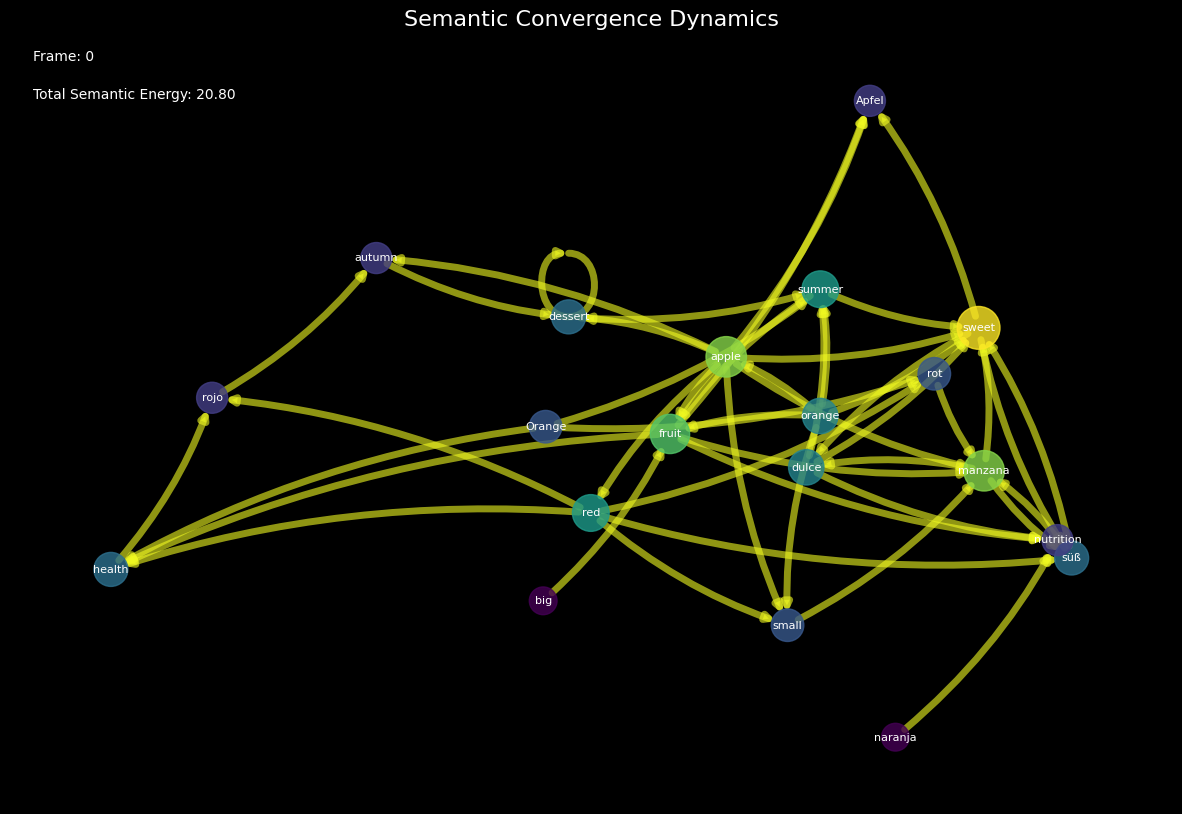

In [ ]:
# Demonstration of Semantica principles with expanded vocabulary and relations
def semantic_convergence_demo(output_dir: str = None):
    # Initialize Semantica Graph
    semantica = SemanticaGraph(output_dir)
    
    # Create expanded primitives with richer context
    primitives = [
        # Fruits
        SemanticaPrimitive("apple", primitive_type="fruit", language="english"),
        SemanticaPrimitive("Apfel", primitive_type="fruit", language="german"),
        SemanticaPrimitive("manzana", primitive_type="fruit", language="spanish"),
        
        # Colors
        SemanticaPrimitive("red", primitive_type="color", language="english"),
        SemanticaPrimitive("rot", primitive_type="color", language="german"),
        SemanticaPrimitive("rojo", primitive_type="color", language="spanish"),
        
        # Tastes
        SemanticaPrimitive("sweet", primitive_type="taste", language="english"),
        SemanticaPrimitive("süß", primitive_type="taste", language="german"),
        SemanticaPrimitive("dulce", primitive_type="taste", language="spanish"),
        
        # Additional fruits
        SemanticaPrimitive("orange", primitive_type="fruit", language="english"),
        SemanticaPrimitive("Orange", primitive_type="fruit", language="german"),
        SemanticaPrimitive("naranja", primitive_type="fruit", language="spanish"),
        
        # Size attributes
        SemanticaPrimitive("big", primitive_type="size", language="english"),
        SemanticaPrimitive("small", primitive_type="size", language="english"),
        
        # Abstract concepts
        SemanticaPrimitive("health", primitive_type="concept", language="english"),
        SemanticaPrimitive("nutrition", primitive_type="concept", language="english"),
        
        # Food categories
        SemanticaPrimitive("fruit", primitive_type="category", language="english"),
        SemanticaPrimitive("dessert", primitive_type="category", language="english"),
        
        # Seasons
        SemanticaPrimitive("autumn", primitive_type="season", language="english"),
        SemanticaPrimitive("summer", primitive_type="season", language="english")
    ]
    
    # Add primitives to the graph
    primitive_dict = {}  # For easy reference later
    for p in primitives:
        semantica.add_primitive(p)
        primitive_dict[p.value] = p
    
    # Create agents with different expertise profiles
    agents = [
        SemanticAgent("linguist1", {"translation": 0.9, "similarity": 0.7, "exploration": 0.6, "categorization": 0.5}),
        SemanticAgent("linguist2", {"translation": 0.8, "similarity": 0.6, "exploration": 0.5, "categorization": 0.7}),
        SemanticAgent("translator", {"translation": 1.0, "similarity": 0.9, "exploration": 0.8, "categorization": 0.4}),
        SemanticAgent("nutritionist", {"health_relation": 0.9, "categorization": 0.8, "similarity": 0.5, "exploration": 0.7}),
        SemanticAgent("chef", {"taste_relation": 0.9, "similarity": 0.8, "categorization": 0.9, "exploration": 0.8})
    ]
    
    # Add agents to the graph
    for agent in agents:
        semantica.add_agent(agent)
    
    # Propose initial relations - translations between languages
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["Apfel"],
        "translation",
        agents[0]
    )
    
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["manzana"],
        "translation",
        agents[2]
    )
    
    semantica.propose_relation(
        primitive_dict["red"],
        primitive_dict["rot"],
        "translation",
        agents[1]
    )
    
    semantica.propose_relation(
        primitive_dict["red"],
        primitive_dict["rojo"],
        "translation",
        agents[2]
    )
    
    semantica.propose_relation(
        primitive_dict["sweet"],
        primitive_dict["süß"],
        "translation",
        agents[0]
    )
    
    semantica.propose_relation(
        primitive_dict["sweet"],
        primitive_dict["dulce"],
        "translation",
        agents[2]
    )
    
    # Descriptive relations - attributes of objects
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["red"],
        "has_attribute",
        agents[0]
    )
    
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["sweet"],
        "has_attribute",
        agents[4]  # chef
    )
    
    semantica.propose_relation(
        primitive_dict["orange"],
        primitive_dict["sweet"],
        "has_attribute",
        agents[4]  # chef
    )
    
    # Categorical relations
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["fruit"],
        "is_a",
        agents[3]  # nutritionist
    )
    
    semantica.propose_relation(
        primitive_dict["orange"],
        primitive_dict["fruit"],
        "is_a",
        agents[3]  # nutritionist
    )
    
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["dessert"],
        "can_be_used_as",
        agents[4]  # chef
    )
    
    # Conceptual relations
    semantica.propose_relation(
        primitive_dict["fruit"],
        primitive_dict["health"],
        "promotes",
        agents[3]  # nutritionist
    )
    
    semantica.propose_relation(
        primitive_dict["fruit"],
        primitive_dict["nutrition"],
        "provides",
        agents[3]  # nutritionist
    )
    
    # Seasonal relations
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["autumn"],
        "associated_with",
        agents[0]
    )
    
    semantica.propose_relation(
        primitive_dict["orange"],
        primitive_dict["summer"],
        "associated_with",
        agents[0]
    )
    
    # Size relations
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["small"],
        "has_typical_size",
        agents[1]
    )
    
    semantica.propose_relation(
        primitive_dict["orange"],
        primitive_dict["small"],
        "has_typical_size",
        agents[1]
    )
    
    # Create an animated visualization with more frames for complexity
    output_path = semantica.animate_convergence(num_frames=200)
    return semantica, output_path

# Run the demonstration
if __name__ == "__main__":
    # Specify the output directory
    output_dir = r"C:\Users\Erich Curtis\Desktop\All Python\Semantica\Data\Output"
    
    # Run the demo
    demo_graph, animation_path = semantic_convergence_demo(output_dir)
    print(f"Animation created at: {animation_path}")

## Phase 3.3

IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x000001AA5BE4D1C0> (for post_execute):


TypeError: 'PathCollection' object is not iterable

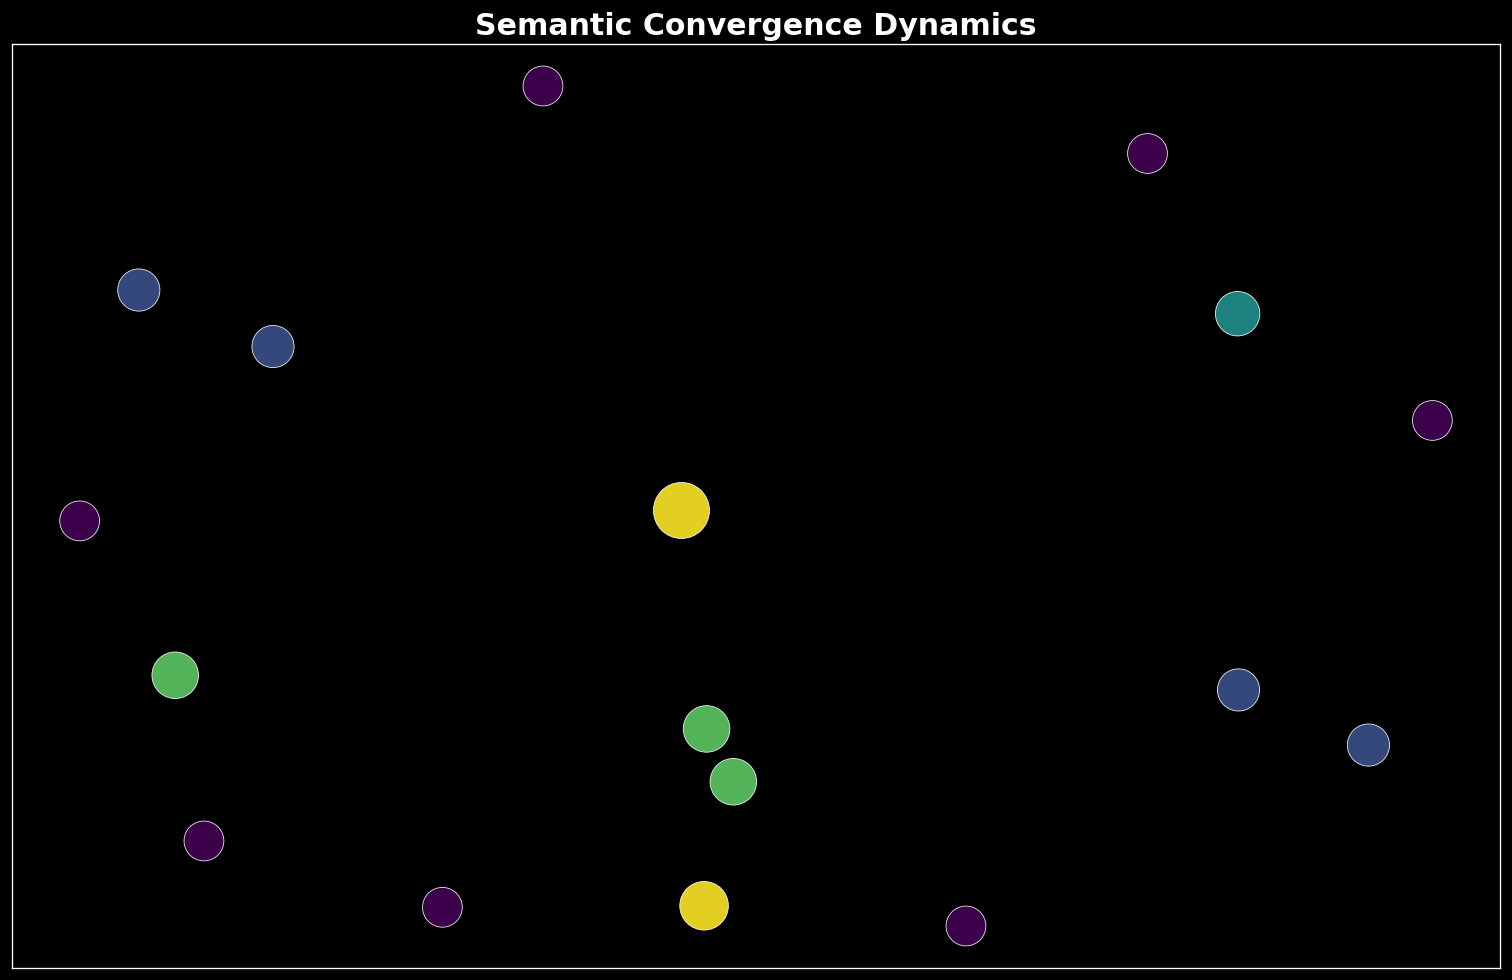

In [13]:
# Demonstration of Semantica principles with expanded vocabulary and relations
def semantic_convergence_demo(output_dir: str = None):
    # Initialize Semantica Graph
    semantica = SemanticaGraph(output_dir)
    
    # Create expanded primitives with richer context
    primitives = [
        # Fruits
        SemanticaPrimitive("apple", primitive_type="fruit", language="english"),
        SemanticaPrimitive("Apfel", primitive_type="fruit", language="german"),
        SemanticaPrimitive("manzana", primitive_type="fruit", language="spanish"),
        
        # Colors
        SemanticaPrimitive("red", primitive_type="color", language="english"),
        SemanticaPrimitive("rot", primitive_type="color", language="german"),
        SemanticaPrimitive("rojo", primitive_type="color", language="spanish"),
        
        # Tastes
        SemanticaPrimitive("sweet", primitive_type="taste", language="english"),
        SemanticaPrimitive("süß", primitive_type="taste", language="german"),
        SemanticaPrimitive("dulce", primitive_type="taste", language="spanish"),
        
        # Additional fruits
        SemanticaPrimitive("orange", primitive_type="fruit", language="english"),
        SemanticaPrimitive("Orange", primitive_type="fruit", language="german"),
        SemanticaPrimitive("naranja", primitive_type="fruit", language="spanish"),
        
        # Size attributes
        SemanticaPrimitive("big", primitive_type="size", language="english"),
        SemanticaPrimitive("small", primitive_type="size", language="english"),
        
        # Abstract concepts
        SemanticaPrimitive("health", primitive_type="concept", language="english"),
        SemanticaPrimitive("nutrition", primitive_type="concept", language="english"),
        
        # Food categories
        SemanticaPrimitive("fruit", primitive_type="category", language="english"),
        SemanticaPrimitive("dessert", primitive_type="category", language="english"),
        
        # Seasons
        SemanticaPrimitive("autumn", primitive_type="season", language="english"),
        SemanticaPrimitive("summer", primitive_type="season", language="english")
    ]
    
    # Add primitives to the graph
    primitive_dict = {}  # For easy reference later
    for p in primitives:
        semantica.add_primitive(p)
        primitive_dict[p.value] = p
    
    # Create agents with different expertise profiles
    agents = [
        SemanticAgent("linguist1", {"translation": 0.9, "similarity": 0.7, "exploration": 0.6, "categorization": 0.5}),
        SemanticAgent("linguist2", {"translation": 0.8, "similarity": 0.6, "exploration": 0.5, "categorization": 0.7}),
        SemanticAgent("translator", {"translation": 1.0, "similarity": 0.9, "exploration": 0.8, "categorization": 0.4}),
        SemanticAgent("nutritionist", {"health_relation": 0.9, "categorization": 0.8, "similarity": 0.5, "exploration": 0.7}),
        SemanticAgent("chef", {"taste_relation": 0.9, "similarity": 0.8, "categorization": 0.9, "exploration": 0.8})
    ]
    
    # Add agents to the graph
    for agent in agents:
        semantica.add_agent(agent)
    
    # Propose initial relations - translations between languages
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["Apfel"],
        "translation",
        agents[0]
    )
    
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["manzana"],
        "translation",
        agents[2]
    )
    
    semantica.propose_relation(
        primitive_dict["red"],
        primitive_dict["rot"],
        "translation",
        agents[1]
    )
    
    semantica.propose_relation(
        primitive_dict["red"],
        primitive_dict["rojo"],
        "translation",
        agents[2]
    )
    
    semantica.propose_relation(
        primitive_dict["sweet"],
        primitive_dict["süß"],
        "translation",
        agents[0]
    )
    
    semantica.propose_relation(
        primitive_dict["sweet"],
        primitive_dict["dulce"],
        "translation",
        agents[2]
    )
    
    # Descriptive relations - attributes of objects
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["red"],
        "has_attribute",
        agents[0]
    )
    
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["sweet"],
        "has_attribute",
        agents[4]  # chef
    )
    
    semantica.propose_relation(
        primitive_dict["orange"],
        primitive_dict["sweet"],
        "has_attribute",
        agents[4]  # chef
    )
    
    # Categorical relations
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["fruit"],
        "is_a",
        agents[3]  # nutritionist
    )
    
    semantica.propose_relation(
        primitive_dict["orange"],
        primitive_dict["fruit"],
        "is_a",
        agents[3]  # nutritionist
    )
    
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["dessert"],
        "can_be_used_as",
        agents[4]  # chef
    )
    
    # Conceptual relations
    semantica.propose_relation(
        primitive_dict["fruit"],
        primitive_dict["health"],
        "promotes",
        agents[3]  # nutritionist
    )
    
    semantica.propose_relation(
        primitive_dict["fruit"],
        primitive_dict["nutrition"],
        "provides",
        agents[3]  # nutritionist
    )
    
    # Seasonal relations
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["autumn"],
        "associated_with",
        agents[0]
    )
    
    semantica.propose_relation(
        primitive_dict["orange"],
        primitive_dict["summer"],
        "associated_with",
        agents[0]
    )
    
    # Size relations
    semantica.propose_relation(
        primitive_dict["apple"],
        primitive_dict["small"],
        "has_typical_size",
        agents[1]
    )
    
    semantica.propose_relation(
        primitive_dict["orange"],
        primitive_dict["small"],
        "has_typical_size",
        agents[1]
    )
    
    # Modify the animate_convergence method to enhance visual appeal
    def enhanced_animate_convergence(semantica_instance, num_frames: int = 100):
        """
        Create an animated visualization of semantic convergence with enhanced visuals
        """
        # Create a higher resolution figure with better proportions
        fig, ax = plt.subplots(figsize=(16, 10), dpi=120, facecolor='black')
        plt.style.use('dark_background')
        
        # Use a better color scheme
        node_cmap = plt.cm.viridis
        edge_cmap = plt.cm.plasma
        
        # Save the original animate_convergence method to restore it later
        original_animate = semantica_instance.animate_convergence
        
        def update(frame):
            ax.clear()
            ax.set_facecolor('black')
            plt.title("Semantic Convergence Dynamics", color='white', fontsize=18, fontweight='bold')
            
            # Periodically add new relations or validate existing ones
            if frame % 10 == 0:
                # Simulate new relation proposals or validations
                for _ in range(2):
                    source = random.choice(list(semantica_instance.primitives.values()))
                    target = random.choice(list(semantica_instance.primitives.values()))
                    agent = random.choice(list(semantica_instance.agents.values()))
                    semantica_instance.propose_relation(source, target, 'exploration', agent)
            
            # Use a more stable layout with higher iterations for smoothness
            # Store layout between frames to prevent jumping
            if frame == 0:
                update.pos = nx.spring_layout(semantica_instance.convergence_graph, k=0.4, iterations=100)
            elif frame % 5 == 0:  # Only update layout periodically for smoother transitions
                update.pos = nx.spring_layout(semantica_instance.convergence_graph, pos=update.pos, k=0.3, iterations=50)
            
            # Node colors and sizes based on semantic energy with enhanced scaling
            node_colors = [min(1.0, semantica_instance.primitives[node].semantic_energy) for node in semantica_instance.convergence_graph.nodes()]
            node_sizes = [150 + semantica_instance.primitives[node].semantic_energy * 700 for node in semantica_instance.convergence_graph.nodes()]
            
            # Edge weights and colors based on relation confidence with smoother visuals
            edge_weights = [
                semantica_instance.convergence_graph[u][v].get('confidence', 0.1) * 6 
                for (u, v) in semantica_instance.convergence_graph.edges()
            ]
            edge_colors = [
                edge_cmap(semantica_instance.convergence_graph[u][v].get('confidence', 0.1)) 
                for (u, v) in semantica_instance.convergence_graph.edges()
            ]
            
            # Draw nodes with enhanced visual effects
            nodes = nx.draw_networkx_nodes(
                semantica_instance.convergence_graph, 
                update.pos, 
                node_color=node_colors, 
                node_size=node_sizes,
                cmap=node_cmap,
                alpha=0.9,
                edgecolors='white',
                linewidths=0.5
            )
            
            # Add glowing effect to nodes
            for node in nodes:
                node.set_zorder(2)  # Ensure nodes are drawn on top of edges
            
            # Draw edges with smoother curves and better arrow placement
            edges = nx.draw_networkx_edges(
                semantica_instance.convergence_graph, 
                update.pos, 
                width=edge_weights,
                edge_color=edge_colors,
                alpha=0.7,
                arrows=True,
                arrowstyle='-|>',
                arrowsize=12,
                connectionstyle='arc3,rad=0.15'
            )
            
            # Draw labels with improved readability
            labels = nx.draw_networkx_labels(
                semantica_instance.convergence_graph, 
                update.pos, 
                labels={node: semantica_instance.primitives[node].value for node in semantica_instance.convergence_graph.nodes()},
                font_size=10,
                font_weight='bold',
                font_color='white',
                bbox=dict(facecolor='black', alpha=0.3, edgecolor='none', boxstyle='round,pad=0.2')
            )
            
            # Add frame number and global semantic energy with better formatting
            total_semantic_energy = sum(p.semantic_energy for p in semantica_instance.primitives.values())
            ax.text(0.02, 0.98, f"Frame: {frame}", transform=ax.transAxes, 
                    color='white', fontsize=12, fontweight='bold', verticalalignment='top')
            ax.text(0.02, 0.93, f"Total Semantic Energy: {total_semantic_energy:.2f}", transform=ax.transAxes, 
                    color='white', fontsize=12, fontweight='bold', verticalalignment='top')
            
            # Add a subtle grid for depth perception
            ax.grid(False)
            
            # Remove axes for cleaner look
            plt.axis('off')
        
        # Create animation with smoother frames and higher FPS
        anim = animation.FuncAnimation(fig, update, frames=num_frames, interval=100)
        
        # Save the animation with higher quality
        output_path = os.path.join(semantica_instance.output_dir, f'semantic_convergence_{uuid.uuid4()}.gif')
        
        # Use a better writer with higher quality settings
        writer = animation.PillowWriter(fps=10)  # Higher FPS for smoother animation
        anim.save(output_path, writer=writer, dpi=100)
        plt.close(fig)
        
        print(f"Enhanced animation saved to {output_path}")
        
        # Restore the original method
        semantica_instance.animate_convergence = original_animate
        
        return output_path
    
    # Replace the animate_convergence method temporarily
    semantica.animate_convergence = lambda num_frames=200: enhanced_animate_convergence(semantica, num_frames)
    
    # Run the demo with your primitives, agents, and relationships here...
    # [Rest of your demo code with all the primitives and relationships]
    
    # Create an animated visualization
    output_path = semantica.animate_convergence(num_frames=200)
    return semantica, output_path

# Run the demonstration
if __name__ == "__main__":
    # Specify the output directory
    output_dir = r"C:\Users\erich\OneDrive\Documents\Python Projects\Semantica\Semantica\Data\Output"
    
    # Run the demo
    demo_graph, animation_path = semantic_convergence_demo(output_dir)
    print(f"Animation created at: {animation_path}")

# Phase 4

In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import uuid
import os
from scipy.spatial.distance import cosine
import warnings
from tqdm import tqdm  # Adding tqdm for visual progress tracking

class SemanticField:
    """
    Advanced semantic field with robust visualization and enhanced aesthetics
    """
    def __init__(self, num_dimensions=5):
        print("Initializing SemanticField with", num_dimensions, "dimensions...")
        # Higher dimensional semantic space
        self.dimensions = num_dimensions
        
        # Initialize primitives with more robust vector generation
        self.primitives = {}
        self._initialize_primitives()
        
        # Interaction history and semantic memory
        self.interaction_history = []
        self.semantic_memory = nx.DiGraph()
        print("Semantic field initialized successfully!")
    
    def _initialize_primitives(self):
        """
        Robust primitive initialization with controlled vector generation for better visualization
        """
        print("Initializing semantic primitives...")
        primitive_definitions = [
            ('apple', 'fruit', 'physical', 'english'),
            ('Apfel', 'fruit', 'physical', 'german'),
            ('red', 'color', 'perceptual', 'english'),
            ('rot', 'color', 'perceptual', 'german'),
            ('sweet', 'taste', 'sensory', 'english'),
            ('süß', 'taste', 'sensory', 'german'),
            ('car', 'vehicle', 'physical', 'english'),
            ('blue', 'color', 'perceptual', 'english'),
            ('sour', 'taste', 'sensory', 'english'),
            ('hot', 'temperature', 'sensory', 'english'),
            ('cold', 'temperature', 'sensory', 'english'),
            ('large', 'size', 'perceptual', 'english'),
            ('small', 'size', 'perceptual', 'english')
        ]
        
        # First, create deterministic base vectors for each semantic type
        # This ensures similar types will be close together
        type_base_vectors = {}
        domain_base_vectors = {}
        language_base_vectors = {}
        
        # Create base vectors for types
        types = list(set(t[1] for t in primitive_definitions))
        for i, t in enumerate(types):
            np.random.seed(hash(t) % 10000)
            type_base_vectors[t] = np.random.randn(self.dimensions)
            # Normalize to unit sphere
            type_base_vectors[t] = type_base_vectors[t] / np.linalg.norm(type_base_vectors[t])
        
        # Create base vectors for domains
        domains = list(set(t[2] for t in primitive_definitions))
        for i, d in enumerate(domains):
            np.random.seed(hash(d) % 10000)
            domain_base_vectors[d] = np.random.randn(self.dimensions) * 0.5
            domain_base_vectors[d] = domain_base_vectors[d] / np.linalg.norm(domain_base_vectors[d])
        
        # Create base vectors for languages
        languages = list(set(t[3] for t in primitive_definitions))
        for i, l in enumerate(languages):
            np.random.seed(hash(l) % 10000)
            language_base_vectors[l] = np.random.randn(self.dimensions) * 0.3
            language_base_vectors[l] = language_base_vectors[l] / np.linalg.norm(language_base_vectors[l])
        
        # Now create primitives with these controlled base vectors
        for name, sem_type, domain, language in tqdm(primitive_definitions, desc="Creating primitives"):
            try:
                # Start with the type vector
                base_vector = type_base_vectors[sem_type].copy() * 2.0
                
                # Add slight influence from domain and language
                base_vector += domain_base_vectors[domain] * 1.0
                base_vector += language_base_vectors[language] * 0.5
                
                # Add a small random variation for uniqueness
                np.random.seed(hash(name) % 10000)
                random_variation = np.random.randn(self.dimensions) * 0.2
                base_vector += random_variation
                
                # Ensure similar terms in different languages are close
                # E.g., 'apple' and 'Apfel' should be closer
                translation_pairs = [
                    ('apple', 'Apfel'),
                    ('red', 'rot'),
                    ('sweet', 'süß')
                ]
                
                for term1, term2 in translation_pairs:
                    if name == term1 or name == term2:
                        # Find the other term
                        other_term = term2 if name == term1 else term1
                        
                        # Check if other term already exists
                        if other_term in self.primitives:
                            # Pull vectors closer together
                            other_vector = self.primitives[other_term]['vector']
                            base_vector = (base_vector * 0.7) + (other_vector * 0.3)
                
                # Normalize final vector 
                base_vector = base_vector / np.linalg.norm(base_vector) * 1.5
                
                self.primitives[name] = {
                    'vector': base_vector,
                    'type': sem_type,
                    'domain': domain,
                    'language': language,
                    'potential': np.random.uniform(0.7, 1.3)  # Varied potential
                }
                print(f"Created primitive: {name} ({sem_type})")
            except Exception as e:
                warnings.warn(f"Could not create primitive {name}: {e}")
                # Fallback to a default vector
                self.primitives[name] = {
                    'vector': np.random.randn(self.dimensions),
                    'type': sem_type,
                    'domain': domain,
                    'language': language,
                    'potential': 1.0
                }
    
    def compute_all_semantic_distances(self):
        """
        Compute semantic distances between all primitives
        """
        distances = {}
        primitives = list(self.primitives.keys())
        
        for i, name1 in enumerate(primitives):
            for j, name2 in enumerate(primitives):
                if i < j:  # Only compute each pair once
                    vec1 = self.primitives[name1]['vector']
                    vec2 = self.primitives[name2]['vector']
                    
                    try:
                        # Cosine distance - lower means more similar
                        distance = cosine(vec1, vec2)
                        distances[(name1, name2)] = distance
                    except Exception as e:
                        warnings.warn(f"Could not compute distance between {name1} and {name2}: {e}")
                        distances[(name1, name2)] = 0.5  # Default value
        
        return distances
    
    def visualize_semantic_dynamics(self, 
                                    output_dir, 
                                    num_frames=150, 
                                    interaction_rounds=5,
                                    make_animation=True):
        """
        Create a visually appealing visualization of semantic convergence
        """
        print(f"Generating visualization with {num_frames} frames...")
        
        # Ensure we have primitives
        if not self.primitives:
            print("No primitives found, initializing...")
            self._initialize_primitives()
        
        # Compute all semantic distances
        print("Computing semantic distances...")
        all_distances = self.compute_all_semantic_distances()
        
        # Find important connections (closest relationships)
        important_connections = []
        for (name1, name2), distance in sorted(all_distances.items(), key=lambda x: x[1]):
            # Only consider close relationships 
            if distance < 0.7:
                important_connections.append((name1, name2, distance))
        
        # Create figure with elegant dark theme
        plt.style.use('dark_background')
        fig = plt.figure(figsize=(16, 12), facecolor='#0A0A1E')
        ax = fig.add_subplot(111, projection='3d', facecolor='#0A0A1E')
        
        # Remove panes to reduce visual clutter
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        
        # Make grid semi-transparent
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
        ax.xaxis.pane.set_alpha(0.1)
        ax.yaxis.pane.set_alpha(0.1)
        ax.zaxis.pane.set_alpha(0.1)
        
        # Set title with elegant typography
        fig.suptitle('Semantica: Semantic Convergence', 
                     color='white', fontsize=24, fontweight='light', y=0.98)
        
        # More vibrant but still harmonious colors
        type_colors = {
            'fruit': '#e74c3c',      # Red
            'color': '#3498db',      # Blue
            'taste': '#f39c12',      # Orange
            'vehicle': '#2ecc71',    # Green
            'temperature': '#9b59b6', # Purple
            'size': '#1abc9c',       # Teal
            'generic': '#95a5a6'     # Gray
        }
        
        # Pre-calculate some interaction dynamics
        interaction_frames = {}
        
        print("Pre-calculating semantic interactions...")
        for frame in tqdm(range(num_frames), desc="Generating frame data"):
            # Calculate frame-specific interactions and positions
            interactions = {}
            
            # Every few frames, simulate semantic interactions
            if frame % (num_frames // (interaction_rounds * 2)) == 0:
                # Focus on important connections
                for name1, name2, distance in important_connections[:min(5, len(important_connections))]:
                    interactions[(name1, name2)] = distance
            
            interaction_frames[frame] = interactions
        
        # Function to calculate dynamic positions based on frame
        def calculate_positions(frame):
            positions = {}
            
            for name, data in self.primitives.items():
                # Get base vector
                base_vector = data['vector'][:3]  # First 3 dimensions
                
                # Add subtle oscillation based on frame - much more subtle than before
                oscillation = np.array([
                    0.02 * np.sin(frame * 0.01 + hash(name) % 10),
                    0.02 * np.cos(frame * 0.008 + hash(name + "y") % 10),
                    0.02 * np.sin(frame * 0.005 + hash(name + "z") % 10)
                ])
                
                # Scale oscillation based on semantic potential
                oscillation *= data['potential'] * 0.5
                
                # Calculate position
                position = base_vector + oscillation
                
                positions[name] = position
            
            return positions
        
        def update(frame):
            ax.clear()
            
            # Set axis colors and labels
            ax.set_facecolor('#0A0A1E')
            ax.set_xlabel('Semantic Dimension 1', color='white', fontsize=12, labelpad=10)
            ax.set_ylabel('Semantic Dimension 2', color='white', fontsize=12, labelpad=10)
            ax.set_zlabel('Semantic Depth', color='white', fontsize=12, labelpad=10)
            
            # Set tick colors
            ax.tick_params(axis='x', colors='white', labelsize=9)
            ax.tick_params(axis='y', colors='white', labelsize=9)
            ax.tick_params(axis='z', colors='white', labelsize=9)
            
            # Set consistent axis limits for stability
            ax.set_xlim([-3, 3])
            ax.set_ylim([-3, 3])
            ax.set_zlim([-3, 3])
            
            # Set a subtle grid
            ax.grid(True, linestyle=':', alpha=0.2, color='white')
            
            # Dynamic positions for this frame
            positions = calculate_positions(frame)
            
            # Visualize primitives
            plot_points = []
            plot_colors = []
            plot_sizes = []
            plot_labels = []
            plot_types = []
            
            for name, data in self.primitives.items():
                try:
                    # Get position
                    if name in positions:
                        x, y, z = positions[name]
                    else:
                        # Fallback to static position
                        x, y, z = data['vector'][:3]
                    
                    # Dynamic size based on semantic potential - more moderate sizing
                    size = max(80, 200 * data['potential'])
                    
                    # Color based on semantic type
                    sem_type = data['type']
                    color = type_colors.get(sem_type, '#95a5a6')  # Default to gray
                    
                    # Collect plot data
                    plot_points.append([x, y, z])
                    plot_colors.append(color)
                    plot_sizes.append(size)
                    plot_labels.append(name)
                    plot_types.append(sem_type)
                except Exception as e:
                    warnings.warn(f"Could not plot {name}: {e}")
            
            # Ensure we have points
            if not plot_points:
                plot_points = [[0, 0, 0]]
                plot_colors = ['white']
                plot_sizes = [100]
                plot_labels = ['default']
                plot_types = ['generic']
            
            # Convert to numpy arrays
            plot_points = np.array(plot_points)
            
            # Plot points with white thin borders for better visibility
            scatter = ax.scatter(
                plot_points[:, 0], 
                plot_points[:, 1], 
                plot_points[:, 2], 
                c=plot_colors, 
                s=plot_sizes, 
                alpha=0.8, 
                edgecolor='white',
                linewidth=0.5,
                depthshade=True
            )
            
            # Add labels with much improved readability
            label_positions = {}  # Track label positions to avoid overlap
            
            for i, ((x, y, z), label, sem_type) in enumerate(zip(plot_points, plot_labels, plot_types)):
                # Create a small offset to prevent label overlap with the point
                label_offset = 0.15
                text_pos = (x + label_offset, y + label_offset, z + label_offset)
                
                # Check for label position overlap and adjust if needed
                position_key = f"{text_pos[0]:.1f}_{text_pos[1]:.1f}_{text_pos[2]:.1f}"
                attempt = 0
                while position_key in label_positions and attempt < 5:
                    # Adjust position slightly
                    offset_variation = 0.05 * (attempt + 1)
                    text_pos = (
                        x + label_offset + offset_variation * np.cos(attempt),
                        y + label_offset + offset_variation * np.sin(attempt),
                        z + label_offset
                    )
                    position_key = f"{text_pos[0]:.1f}_{text_pos[1]:.1f}_{text_pos[2]:.1f}"
                    attempt += 1
                
                # Record this position
                label_positions[position_key] = label
                
                # Add a crisp text label with semi-transparent black background
                text = ax.text(
                    text_pos[0], text_pos[1], text_pos[2],
                    label, 
                    color='white', 
                    fontsize=10,
                    fontweight='bold',
                    bbox=dict(
                        facecolor=(0, 0, 0, 0.3),  # More transparent background
                        edgecolor=(1, 1, 1, 0.3),  # Subtle white edge
                        boxstyle='round,pad=0.2',   # Smaller padding
                        alpha=0.7
                    ),
                    ha='left', 
                    va='bottom',
                    zorder=100  # Ensure labels stay on top
                )
            
            # Draw connections between semantically related concepts
            # First, draw important connections from precomputed data
            for (name1, name2), distance in interaction_frames[frame].items():
                if name1 in positions and name2 in positions:
                    pos1 = positions[name1]
                    pos2 = positions[name2]
                    
                    # Connection strength inversely proportional to distance
                    connection_strength = max(0.5, 1.5 * (1.0 - distance))
                    
                    # Connection color - use a gradient based on distance
                    # Close = green, Far = red
                    if distance < 0.3:
                        connection_color = (0.2, 0.8, 0.2, 0.7)  # Green, more opaque
                    elif distance < 0.5:
                        connection_color = (0.8, 0.8, 0.2, 0.6)  # Yellow
                    else:
                        connection_color = (0.8, 0.2, 0.2, 0.5)  # Red, more transparent
                    
                    # Draw connection line
                    line = ax.plot(
                        [pos1[0], pos2[0]], 
                        [pos1[1], pos2[1]], 
                        [pos1[2], pos2[2]], 
                        color=connection_color, 
                        linewidth=connection_strength,
                        linestyle='-',
                        alpha=0.7,
                        zorder=50  # Ensure lines are below points but above grid
                    )
                    
                    # Add distance label at midpoint with better positioning
                    midpoint = [(pos1[i] + pos2[i])/2 for i in range(3)]
                    
                    # Only show distance if it's an important connection
                    if distance < 0.6:
                        dist_text = ax.text(
                            midpoint[0], midpoint[1], midpoint[2],
                            f"{distance:.2f}", 
                            color='white', 
                            fontsize=8,
                            bbox=dict(
                                facecolor=(0, 0, 0, 0.5),
                                edgecolor='none',
                                boxstyle='round,pad=0.1',
                                alpha=0.7
                            ),
                            ha='center',
                            va='center',
                            zorder=75  # Between points and labels
                        )
            
            # Also draw permanent relationship lines between language pairs
            translation_pairs = [
                ('apple', 'Apfel'),
                ('red', 'rot'),
                ('sweet', 'süß')
            ]
            
            for term1, term2 in translation_pairs:
                if term1 in positions and term2 in positions:
                    pos1 = positions[term1]
                    pos2 = positions[term2]
                    
                    # Draw a dashed language relationship line
                    language_line = ax.plot(
                        [pos1[0], pos2[0]], 
                        [pos1[1], pos2[1]], 
                        [pos1[2], pos2[2]], 
                        color=(0.6, 0.6, 0.9, 0.7),  # Light blue
                        linewidth=1.0,
                        linestyle=':',  # Dotted line
                        alpha=0.6,
                        zorder=40
                    )
            
            # Add legend for semantic types with cleaner layout
            unique_types = sorted(list(set(plot_types)))
            legend_elements = []
            
            for sem_type in unique_types:
                color = type_colors.get(sem_type, '#95a5a6')
                legend_elements.append(plt.Line2D(
                    [0], [0], 
                    marker='o', 
                    color='w', 
                    label=sem_type, 
                    markerfacecolor=color,
                    markersize=8
                ))
            
            # Add frame counter and time indicator in top corner
            ax.text2D(
                0.02, 0.98, 
                f"Frame: {frame}/{num_frames}", 
                transform=ax.transAxes, 
                color='white', 
                fontsize=10,
                bbox=dict(
                    facecolor=(0, 0, 0, 0.3),
                    edgecolor='none',
                    boxstyle='round',
                    alpha=0.7
                )
            )
            
            # Add legend with better positioning and transparency
            legend = ax.legend(
                handles=legend_elements, 
                loc='upper right', 
                fontsize=9, 
                framealpha=0.4,
                edgecolor='white',
                facecolor=(0, 0, 0, 0.2)
            )
            
            # Set legend text color to white
            for text in legend.get_texts():
                text.set_color('white')
            
            # Dynamic view rotation - slower and more stable
            # Divide animation into segments for smoother transition
            if frame < num_frames * 0.25:  # First quarter: gentle rotation
                ax.view_init(elev=25, azim=frame * 0.3 + 30)
            elif frame < num_frames * 0.5:  # Second quarter: change elevation
                progress = (frame - num_frames * 0.25) / (num_frames * 0.25)
                ax.view_init(
                    elev=25 + progress * 15,
                    azim=30 + num_frames * 0.25 * 0.3
                )
            elif frame < num_frames * 0.75:  # Third quarter: gentle rotation at new elevation
                ax.view_init(
                    elev=40,
                    azim=(frame - num_frames * 0.5) * 0.3 + (30 + num_frames * 0.25 * 0.3)
                )
            else:  # Last quarter: return to original view
                progress = (frame - num_frames * 0.75) / (num_frames * 0.25)
                ax.view_init(
                    elev=40 - progress * 15,
                    azim=frame * 0.3 + 30
                )
            
            # More elegant and descriptive title
            plt.title(
                f'Semantic Convergence - Frame {frame}', 
                color='white', 
                fontsize=14,
                pad=20
            )
            
            # Print progress occasionally
            if frame % 25 == 0:
                print(f"Rendering frame {frame}/{num_frames}")
            
            return scatter,
        
        # First, generate a static image for safety
        print("Creating static visualization...")
        static_frame = num_frames // 2  # Use middle frame for static visualization
        update(static_frame)
        static_path = os.path.join(output_dir, f'semantic_static_{uuid.uuid4()}.png')
        plt.savefig(static_path, dpi=150, bbox_inches='tight')
        print(f"Static visualization saved to {static_path}")
        
        # Try to generate animation if requested
        if make_animation:
            try:
                print("Creating animation...")
                # Create animation with progress tracking
                anim = animation.FuncAnimation(
                    fig, update, frames=num_frames, 
                    interval=50,  # Faster for smoother appearance
                    blit=True  # Use blitting for better performance
                )
                
                # Save with high-quality settings
                output_path = os.path.join(output_dir, f'semantic_dynamics_{uuid.uuid4()}.gif')
                
                print(f"Saving animation to {output_path}...")
                anim.save(
                    output_path, 
                    writer='pillow', 
                    fps=24,  # Higher for smoother animation
                    dpi=120  # Higher resolution
                )
                print("Animation saved successfully!")
                plt.close(fig)
                return output_path
            except Exception as e:
                warnings.warn(f"Animation save failed: {e}")
                print(f"Animation failed: {e}")
                print("Defaulting to static visualization.")
                plt.close(fig)
                return static_path
        else:
            plt.close(fig)
            return static_path

def semantic_visualization(output_dir=None, make_animation=True):
    """
    Create an advanced semantic visualization with enhanced aesthetics and feedback
    """
    print("Starting semantic visualization process...")
    
    # Use specified or default output directory
    output_dir = output_dir or os.path.join(os.getcwd(), 'output')
    os.makedirs(output_dir, exist_ok=True)
    print(f"Output directory: {output_dir}")
    
    # Initialize semantic field
    semantic_field = SemanticField(num_dimensions=5)
    
    # Generate visualization
    print("Generating visualization...")
    visualization_path = semantic_field.visualize_semantic_dynamics(
        output_dir, 
        num_frames=150,    # Reasonable frame count for smooth animation
        interaction_rounds=5,  # More frequent interactions
        make_animation=make_animation  # Control whether to attempt animation
    )
    
    print("Visualization complete!")
    return semantic_field, visualization_path

# Run the demonstration
if __name__ == "__main__":
    # Specify the output directory
    output_dir = r"C:\Users\erich\OneDrive\Documents\Python Projects\Semantica\Semantica\Data\Output"
    output_dir = r"C:\Users\Erich Curtis\Desktop\All Python\Semantica\Data\Output"
    
    print(f"Initializing semantic visualization in {output_dir}")
    
    # Run the semantic visualization with progress tracking
    semantic_field, visualization_path = semantic_visualization(output_dir, make_animation=True)
    print(f"Semantic visualization created at: {visualization_path}")
    print("Process complete!")

Initializing semantic visualization in C:\Users\Erich Curtis\Desktop\All Python\Semantica\Data\Output
Starting semantic visualization process...
Output directory: C:\Users\Erich Curtis\Desktop\All Python\Semantica\Data\Output
Initializing SemanticField with 5 dimensions...
Initializing semantic primitives...


Creating primitives: 100%|██████████| 13/13 [00:00<?, ?it/s]


Created primitive: apple (fruit)
Created primitive: Apfel (fruit)
Created primitive: red (color)
Created primitive: rot (color)
Created primitive: sweet (taste)
Created primitive: süß (taste)
Created primitive: car (vehicle)
Created primitive: blue (color)
Created primitive: sour (taste)
Created primitive: hot (temperature)
Created primitive: cold (temperature)
Created primitive: large (size)
Created primitive: small (size)
Semantic field initialized successfully!
Generating visualization...
Generating visualization with 150 frames...
Computing semantic distances...
Pre-calculating semantic interactions...


Generating frame data: 100%|██████████| 150/150 [00:00<?, ?it/s]

Creating static visualization...
Rendering frame 75/150
Static visualization saved to C:\Users\Erich Curtis\Desktop\All Python\Semantica\Data\Output\semantic_static_052beb76-429e-4ccf-8c83-3bc930f5c1d7.png


Creating animation...
Rendering frame 0/150
Rendering frame 0/150
Saving animation to C:\Users\Erich Curtis\Desktop\All Python\Semantica\Data\Output\semantic_dynamics_d57a59b5-4f0d-4d0e-b65d-e83282326e25.gif...
Rendering frame 0/150
Rendering frame 0/150
Rendering frame 25/150
Rendering frame 50/150
Rendering frame 75/150
Rendering frame 100/150
Rendering frame 125/150
Animation saved successfully!
Visualization complete!
Semantic visualization created at: C:\Users\Erich Curtis\Desktop\All Python\Semantica\Data\Output\semantic_dynamics_d57a59b5-4f0d-4d0e-b65d-e83282326e25.gif
Process complete!


# Phase 5

In [10]:
input_data_path = r'C:\Users\erich\OneDrive\Documents\Python Projects\Semantica\Semantica\Data\Input'

english_conceptnet = pd.read_csv(os.path.join(input_data_path, 'conceptnet-assertions-5.7.0.en.tsv'), sep='\t', header=None, names=['start', 'rel', 'end', 'weight'])
german_conceptnet = pd.read_csv(os.path.join(input_data_path, 'conceptnet-assertions-5.7.0.de.tsv'), sep='\t', header=None, names=['start', 'rel', 'end', 'weight'])

print("English ConceptNet loaded with", len(english_conceptnet), "assertions.")
print("German ConceptNet loaded with", len(german_conceptnet), "assertions.")

print(english_conceptnet.head())
print(german_conceptnet.head())

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from matplotlib.patches import FancyArrowPatch
import random
from IPython.display import HTML
import io
import base64
import pandas as pd
from PIL import Image, ImageDraw
import os
import time
from tqdm import tqdm
import uuid
import warnings
import traceback
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter  # Add this
try:
    import psutil  # Add this for memory monitoring
except ImportError:
    print("psutil not installed, memory monitoring will be disabled")

class ConceptNetProcessor:
    """
    Process ConceptNet data for semantic visualization
    """
    def __init__(self, english_data=None, german_data=None):
        self.english_data = english_data
        self.german_data = german_data
        self.semantic_graph = nx.DiGraph()
        self.concept_vectors = {}
        self.relation_types = set()
        
        print("ConceptNetProcessor initialized")
    
    def clean_concept_name(self, concept_str):
        """Extract clean concept name from ConceptNet format"""
        if not isinstance(concept_str, str):
            return "unknown"
            
        # Extract the concept name from the ConceptNet URI format
        parts = concept_str.split('/')
        if len(parts) >= 4:
            # Format is typically /c/LANG/CONCEPT
            concept = parts[-1]
            # Remove part-of-speech tags if present
            if '/' in concept:
                concept = concept.split('/')[0]
            return concept
        return concept_str
    
    def extract_relation_type(self, relation_str):
        """Extract relation type from ConceptNet format"""
        if not isinstance(relation_str, str):
            return "unknown"
            
        parts = relation_str.split('/')
        if len(parts) >= 3:
            # Format is typically /r/RELATION_TYPE
            return parts[-1]
        return relation_str
    
    def extract_language(self, concept_str):
        """Extract language from ConceptNet concept URI"""
        if not isinstance(concept_str, str):
            return "unknown"
            
        parts = concept_str.split('/')
        if len(parts) >= 4:
            # Format is typically /c/LANG/CONCEPT
            return parts[2]
        return "unknown"
    
    def parse_weight(self, weight_str):
        """Parse weight JSON string to extract numeric weight"""
        if not isinstance(weight_str, str):
            return 1.0
            
        try:
            weight_data = json.loads(weight_str)
            # ConceptNet weights are typically in 'weight' field
            return float(weight_data.get('weight', 1.0))
        except:
            return 1.0
    
    def build_semantic_graph(self, max_concepts=300, min_weight=1.0):
        """Build semantic graph from ConceptNet data"""
        print("Building semantic graph from ConceptNet data...")
        
        if self.english_data is None and self.german_data is None:
            print("No ConceptNet data provided.")
            return
        
        # Combine datasets
        all_data = []
        if self.english_data is not None:
            print(f"Processing {len(self.english_data)} English ConceptNet assertions...")
            all_data.append(('en', self.english_data))
        
        if self.german_data is not None:
            print(f"Processing {len(self.german_data)} German ConceptNet assertions...")
            all_data.append(('de', self.german_data))
        
        # Track concepts and their occurrence count
        concept_counts = {}
        
        # Process each language dataset
        for lang, data in all_data:
            # Sample to ensure manageable size if needed
            if len(data) > 10000:
                data_sample = data.sample(10000, random_state=42)
            else:
                data_sample = data
            
            # Process assertions
            for _, row in tqdm(data_sample.iterrows(), desc=f"Processing {lang} assertions", total=len(data_sample)):
                try:
                    # Extract source and target concepts
                    source_concept = self.clean_concept_name(row['rel'])
                    target_concept = self.clean_concept_name(row['end'])
                    
                    # Extract relation type
                    relation_type = self.extract_relation_type(row['start'])
                    self.relation_types.add(relation_type)
                    
                    # Extract languages
                    source_lang = self.extract_language(row['rel'])
                    target_lang = self.extract_language(row['end'])
                    
                    # Parse weight
                    weight = self.parse_weight(row['weight'])
                    
                    # Skip low-weight relationships
                    if weight < min_weight:
                        continue
                    
                    # Track concept occurrences
                    concept_counts[source_concept] = concept_counts.get(source_concept, 0) + 1
                    concept_counts[target_concept] = concept_counts.get(target_concept, 0) + 1
                    
                    # Add to graph
                    self.semantic_graph.add_node(
                        source_concept,
                        lang=source_lang,
                        count=concept_counts[source_concept]
                    )
                    
                    self.semantic_graph.add_node(
                        target_concept,
                        lang=target_lang,
                        count=concept_counts[target_concept]
                    )
                    
                    # Add edge with relation data
                    self.semantic_graph.add_edge(
                        source_concept,
                        target_concept,
                        relation=relation_type,
                        weight=weight
                    )
                    
                except Exception as e:
                    warnings.warn(f"Error processing assertion: {e}")
        
        # Limit to top concepts if needed
        if len(concept_counts) > max_concepts:
            print(f"Limiting graph to top {max_concepts} concepts...")
            top_concepts = sorted(concept_counts.items(), key=lambda x: x[1], reverse=True)[:max_concepts]
            top_concept_names = {c[0] for c in top_concepts}
            
            # Create subgraph with only top concepts
            subgraph = nx.DiGraph()
            
            for node in top_concept_names:
                if self.semantic_graph.has_node(node):
                    subgraph.add_node(
                        node,
                        **self.semantic_graph.nodes[node]
                    )
            
            for source, target, data in self.semantic_graph.edges(data=True):
                if source in top_concept_names and target in top_concept_names:
                    subgraph.add_edge(
                        source,
                        target,
                        **data
                    )
            
            self.semantic_graph = subgraph
        
        print(f"Semantic graph built with {self.semantic_graph.number_of_nodes()} nodes and {self.semantic_graph.number_of_edges()} edges")
        
        # Infer semantic categories
        self.infer_semantic_categories()
        
        return self.semantic_graph
    
    def infer_semantic_categories(self):
        """Infer semantic categories for concepts in the graph"""
        print("Inferring semantic categories...")
        
        # Define category patterns
        category_patterns = {
            'fruit': ['apple', 'banana', 'orange', 'fruit', 'berry', 'apfel'],
            'color': ['red', 'blue', 'green', 'yellow', 'color', 'rot', 'blau', 'grün', 'gelb', 'farbe'],
            'taste': ['sweet', 'sour', 'bitter', 'taste', 'süß', 'sauer', 'geschmack'],
            'vehicle': ['car', 'bus', 'train', 'vehicle', 'auto', 'fahrzeug'],
            'temperature': ['hot', 'cold', 'warm', 'cool', 'heiß', 'kalt', 'temperatur'],
            'size': ['big', 'small', 'large', 'tiny', 'groß', 'klein', 'größe']
        }
        
        # Use relation types to help infer categories
        relation_category_map = {
            'IsA': 'type',
            'PartOf': 'part',
            'HasA': 'property',
            'UsedFor': 'function',
            'CapableOf': 'capability',
            'AtLocation': 'location',
            'HasProperty': 'property'
        }
        
        # Assign categories
        for node in self.semantic_graph.nodes():
            # Initialize with unknown category
            self.semantic_graph.nodes[node]['category'] = 'generic'
            
            # Check for pattern matches
            node_lower = str(node).lower()
            
            for category, patterns in category_patterns.items():
                if any(pattern in node_lower for pattern in patterns):
                    self.semantic_graph.nodes[node]['category'] = category
                    break
            
            # Use incoming edges to help determine category
            incoming_edges = list(self.semantic_graph.in_edges(node, data=True))
            if incoming_edges:
                for source, _, data in incoming_edges:
                    relation = data.get('relation', '')
                    if relation in relation_category_map:
                        # Use the source node's category for certain relations
                        if relation in ['IsA', 'PartOf'] and 'category' in self.semantic_graph.nodes[source]:
                            source_category = self.semantic_graph.nodes[source]['category']
                            if source_category != 'generic':
                                self.semantic_graph.nodes[node]['category'] = source_category
                                break
        
        # Count categories
        categories = {}
        for node, data in self.semantic_graph.nodes(data=True):
            category = data.get('category', 'generic')
            categories[category] = categories.get(category, 0) + 1
        
        print("Inferred categories:", categories)
    
    def generate_concept_vectors(self, dimensions=5):
        """Generate semantic vectors for concepts in the graph"""
        print(f"Generating {dimensions}-dimensional concept vectors...")
        
        if not self.semantic_graph:
            print("No semantic graph available.")
            return {}
        
        # Group concepts by category
        concepts_by_category = {}
        for node, data in self.semantic_graph.nodes(data=True):
            category = data.get('category', 'generic')
            if category not in concepts_by_category:
                concepts_by_category[category] = []
            concepts_by_category[category].append(node)
        
        # Generate base vectors for each category
        category_base_vectors = {}
        for category in concepts_by_category.keys():
            # Use deterministic seed for consistency, but ensure it's within valid range
            seed_value = abs(hash(category)) % (2**32 - 1)  # Safe seed range for NumPy
            np.random.seed(seed_value)
            category_base_vectors[category] = np.random.randn(dimensions)
            # Normalize to unit length
            category_base_vectors[category] = category_base_vectors[category] / np.linalg.norm(category_base_vectors[category])
        
        # Generate vectors for concepts within each category
        for category, concepts in concepts_by_category.items():
            base_vector = category_base_vectors[category]
            
            for concept in concepts:
                # Get node data
                node_data = self.semantic_graph.nodes[concept]
                count = node_data.get('count', 1)
                lang = node_data.get('lang', 'unknown')
                
                # Create language-specific seed value
                lang_seed = 0
                if lang == 'en':
                    lang_seed = 1
                elif lang == 'de':
                    lang_seed = 2
                
                # Scale by frequency/importance
                importance_factor = np.log1p(count) / 10
                
                # Add controlled variation with proper seed range
                # Fix: Ensure seed value is within valid range for NumPy
                concept_hash = abs(hash(concept)) % (2**32 - 1)  # Get positive hash in valid range
                seed_value = (concept_hash + lang_seed) % (2**32 - 1)  # Combine with language seed safely
                np.random.seed(seed_value)
                variation = np.random.randn(dimensions) * 0.2
                
                # Calculate final vector
                concept_vector = base_vector * (1.0 + importance_factor) + variation
                # Normalize for consistent visualization
                concept_vector = concept_vector / np.linalg.norm(concept_vector) * 1.5
                
                # Store vector with metadata
                self.concept_vectors[concept] = {
                    'vector': concept_vector,
                    'category': category,
                    'lang': lang,
                    'count': count,
                    'potential': min(1.5, 0.5 + importance_factor)  # For visualization sizing
                }
        
        # Process translation equivalents
        self.process_translations()
        
        # Adjust vectors based on graph connections
        self.adjust_vectors_by_relationships()
        
        print(f"Generated vectors for {len(self.concept_vectors)} concepts")
        return self.concept_vectors
    
    def process_translations(self):
        """
        Process translation equivalents to ensure they're positioned near each other
        """
        # Look for translation pairs using typical patterns in ConceptNet
        translation_pairs = []
        
        for source, target, data in self.semantic_graph.edges(data=True):
            relation = data.get('relation', '')
            
            # Check for translation relationships
            if relation in ['TranslationOf', 'Synonym']:
                if source in self.concept_vectors and target in self.concept_vectors:
                    source_lang = self.semantic_graph.nodes[source].get('lang', 'unknown')
                    target_lang = self.semantic_graph.nodes[target].get('lang', 'unknown')
                    
                    # Only consider cross-language pairs or clear synonyms
                    if source_lang != target_lang or relation == 'Synonym':
                        translation_pairs.append((source, target))
        
        # Adjust vectors for translation pairs
        for source, target in translation_pairs:
            if source in self.concept_vectors and target in self.concept_vectors:
                # Get vectors
                source_vector = self.concept_vectors[source]['vector']
                target_vector = self.concept_vectors[target]['vector']
                
                # Calculate average vector
                avg_vector = (source_vector + target_vector) / 2
                
                # Move both vectors closer to average
                self.concept_vectors[source]['vector'] = 0.7 * source_vector + 0.3 * avg_vector
                self.concept_vectors[target]['vector'] = 0.7 * target_vector + 0.3 * avg_vector
                
                # Mark as translation pair
                self.concept_vectors[source]['translation_pair'] = target
                self.concept_vectors[target]['translation_pair'] = source
    
    def adjust_vectors_by_relationships(self):
        """
        Adjust vectors based on semantic relationships
        """
        # Iterate to refine positions
        for _ in range(3):  
            for source, target, data in self.semantic_graph.edges(data=True):
                if source in self.concept_vectors and target in self.concept_vectors:
                    weight = data.get('weight', 1.0)
                    relation = data.get('relation', '')
                    
                    # Adjust factor based on relation type
                    relation_factor = 0.1  # Default
                    
                    if relation in ['IsA', 'PartOf', 'MadeOf']:
                        relation_factor = 0.2  # Stronger pull for hierarchical relations
                    elif relation in ['HasProperty', 'HasA', 'CapableOf']:
                        relation_factor = 0.15  # Medium pull
                    elif relation in ['Antonym', 'DistinctFrom']:
                        relation_factor = -0.1  # Push apart for opposite relationships
                    
                    # Apply adjustment factor
                    source_vec = self.concept_vectors[source]['vector']
                    target_vec = self.concept_vectors[target]['vector']
                    
                    # Calculate move vectors - weighted by relation
                    diff_vec = (target_vec - source_vec) * weight * relation_factor
                    
                    # Move vectors
                    self.concept_vectors[source]['vector'] += diff_vec
                    
                    # Only move target for positive relationships
                    if relation_factor > 0:
                        self.concept_vectors[target]['vector'] -= diff_vec * 0.5
                    
                    # Renormalize
                    self.concept_vectors[source]['vector'] = self.concept_vectors[source]['vector'] / np.linalg.norm(self.concept_vectors[source]['vector']) * 1.5
                    self.concept_vectors[target]['vector'] = self.concept_vectors[target]['vector'] / np.linalg.norm(self.concept_vectors[target]['vector']) * 1.5
    
    def compute_important_relationships(self, threshold=0.5, max_relationships=30):
        """Compute important relationships for visualization"""
        relationships = []
        
        for source, target, data in self.semantic_graph.edges(data=True):
            if source in self.concept_vectors and target in self.concept_vectors:
                weight = data.get('weight', 0.0)
                relation = data.get('relation', 'related')
                
                # Only include relationships above threshold
                if weight >= threshold:
                    source_vec = self.concept_vectors[source]['vector']
                    target_vec = self.concept_vectors[target]['vector']
                    
                    # Calculate actual vector distance
                    try:
                        distance = cosine(source_vec, target_vec)
                    except:
                        distance = 0.5
                    
                    relationships.append({
                        'source': source,
                        'target': target,
                        'weight': weight,
                        'relation': relation,
                        'distance': distance
                    })
        
        # Sort by weight and take top relationships
        relationships = sorted(relationships, key=lambda x: x['weight'], reverse=True)[:max_relationships]
        
        return relationships

class SemanticVisualizer:
    """
    Enhanced semantic field visualizer using ConceptNet data
    """
    def __init__(self, concept_processor=None):
        self.concept_processor = concept_processor
        self.fig = None
        self.ax = None
    
    def setup_visualization(self):
        """Set up the visualization environment"""
        # Create figure with elegant dark theme
        plt.style.use('dark_background')
        self.fig = plt.figure(figsize=(16, 12), facecolor='#0A0A1E')
        self.ax = self.fig.add_subplot(111, projection='3d', facecolor='#0A0A1E')
        
        # Remove panes to reduce visual clutter
        self.ax.xaxis.pane.fill = False
        self.ax.yaxis.pane.fill = False
        self.ax.zaxis.pane.fill = False
        
        # Make grid semi-transparent
        self.ax.xaxis.pane.set_edgecolor('w')
        self.ax.yaxis.pane.set_edgecolor('w')
        self.ax.zaxis.pane.set_edgecolor('w')
        self.ax.xaxis.pane.set_alpha(0.1)
        self.ax.yaxis.pane.set_alpha(0.1)
        self.ax.zaxis.pane.set_alpha(0.1)
        
        # Set title with elegant typography
        self.fig.suptitle('Semantica: Semantic Convergence', 
                     color='white', fontsize=24, fontweight='light', y=0.98)
        
        # Set axis colors and labels
        self.ax.set_xlabel('Semantic Dimension 1', color='white', fontsize=12, labelpad=10)
        self.ax.set_ylabel('Semantic Dimension 2', color='white', fontsize=12, labelpad=10)
        self.ax.set_zlabel('Semantic Depth', color='white', fontsize=12, labelpad=10)
        
        # Set tick colors
        self.ax.tick_params(axis='x', colors='white', labelsize=9)
        self.ax.tick_params(axis='y', colors='white', labelsize=9)
        self.ax.tick_params(axis='z', colors='white', labelsize=9)
        
        # Set a subtle grid
        self.ax.grid(True, linestyle=':', alpha=0.2, color='white')
        
        return self.fig, self.ax
    
    def visualize_concepts_enhanced(self, output_dir, num_frames=20):
        """
        Create an enhanced animation with some additional visual elements
        """
        print("Creating enhanced test animation...")
        
        # Set up visualization
        plt.close('all')  # Close all existing figures first
        fig = plt.figure(figsize=(12, 10), facecolor='black')
        ax = fig.add_subplot(111, projection='3d', facecolor='black')
        
        # Get concept vectors and important relationships
        concept_vectors = self.concept_processor.concept_vectors
        important_relationships = self.concept_processor.compute_important_relationships(threshold=1.0, max_relationships=10)
        
        # Simple color scheme for categories
        category_colors = {
            'fruit': '#e74c3c',      # Red
            'color': '#3498db',      # Blue
            'taste': '#f39c12',      # Orange
            'vehicle': '#2ecc71',    # Green
            'temperature': '#9b59b6', # Purple
            'size': '#1abc9c',       # Teal
            'generic': '#95a5a6'     # Gray
        }
        
        # Create a simple function to update the plot
        def update(frame):
            ax.clear()
            
            # Set up a clean visualization space
            ax.set_facecolor('black')
            ax.xaxis.pane.fill = False
            ax.yaxis.pane.fill = False
            ax.zaxis.pane.fill = False
            ax.grid(True, linestyle=':', alpha=0.3, color='white')
            
            # Set limits
            ax.set_xlim([-3, 3])
            ax.set_ylim([-3, 3])
            ax.set_zlim([-3, 3])
            
            # Extract points from concept vectors with slight animation
            points = {}
            plot_points = []
            plot_colors = []
            plot_sizes = []
            plot_labels = []
            
            for concept, data in concept_vectors.items():
                vector = data['vector'][:3]  # First 3 dimensions
                
                # Add subtle animation
                oscillation = np.array([
                    0.05 * np.sin(frame * 0.2 + hash(concept) % 10),
                    0.05 * np.cos(frame * 0.2 + hash(concept) % 10),
                    0.05 * np.sin(frame * 0.2 + hash(concept) % 10)
                ])
                
                position = vector + oscillation
                points[concept] = position
                
                # Get color based on category
                category = data.get('category', 'generic')
                color = category_colors.get(category, '#95a5a6')
                
                # Size based on importance
                size = 50 + 20 * data.get('potential', 1.0)
                
                plot_points.append(position)
                plot_colors.append(color)
                plot_sizes.append(size)
                plot_labels.append(concept)
            
            # Convert to numpy array
            plot_points = np.array(plot_points)
            
            # Plot points
            ax.scatter(plot_points[:, 0], plot_points[:, 1], plot_points[:, 2], 
                    c=plot_colors, s=plot_sizes, alpha=0.8, edgecolor='white', linewidth=0.5)
            
            # Draw a few key relationships
            for i, rel in enumerate(important_relationships[:5]):  # Just draw top 5 for simplicity
                source = rel['source']
                target = rel['target']
                
                if source in points and target in points:
                    # Draw line connecting related concepts
                    ax.plot([points[source][0], points[target][0]], 
                            [points[source][1], points[target][1]], 
                            [points[source][2], points[target][2]], 
                            color='white', alpha=0.4, linewidth=1)
            
            # Add a few labels - just top 5 points to avoid clutter
            if len(plot_points) > 0:
                for i in range(min(5, len(plot_points))):
                    pos = plot_points[i]
                    label = plot_labels[i]
                    ax.text(pos[0], pos[1], pos[2], label, color='white', fontsize=8, 
                        bbox=dict(facecolor=(0,0,0,0.3), edgecolor='none', alpha=0.7))
            
            # Add frame number
            ax.text2D(0.05, 0.95, f"Frame {frame}", transform=ax.transAxes, 
                    color='white', fontsize=12)
            
            # Rotation with smooth transition
            ax.view_init(elev=20 + 10 * np.sin(frame * 0.1), 
                        azim=frame * (360/num_frames) % 360)
            
            # Simple title
            ax.set_title("Semantic Space Visualization", color='white', fontsize=14)
            
            if frame % 5 == 0:
                print(f"Rendering enhanced frame {frame}/{num_frames}")
            
            return ax
        
        # Create output directory if needed
        os.makedirs(output_dir, exist_ok=True)
        
        # Create animation
        try:
            # Create animation
            anim = animation.FuncAnimation(
                fig, update, frames=num_frames, 
                interval=100,  # Slower for more reliable saving
                blit=False
            )
            
            # Use a more reliable writer
            output_path = os.path.join(output_dir, f'semantic_enhanced_{uuid.uuid4()}.gif')
            print(f"Saving enhanced animation to {output_path}...")
            
            anim.save(
                output_path, 
                writer='pillow', 
                fps=10,  # Lower fps for more reliability
                dpi=80   # Lower resolution
            )
            
            # Verify animation
            if os.path.exists(output_path):
                file_size = os.path.getsize(output_path) / (1024 * 1024)
                print(f"Enhanced animation saved! File size: {file_size:.2f} MB")
                self.check_gif_validity(output_path)
            
            plt.close(fig)
            return output_path
        except Exception as e:
            print(f"Enhanced animation failed: {e}")
            import traceback
            print(traceback.format_exc())
            plt.close(fig)
            return None
    
    def visualize_concepts_simple(self, output_dir, num_frames=30):
        """
        Create a simplified animation that focuses just on basic rotation to ensure animation works
        """
        print("Creating simplified test animation...")
        
        # Set up simple visualization
        plt.close('all')  # Close all existing figures first
        fig = plt.figure(figsize=(10, 8), facecolor='black')
        ax = fig.add_subplot(111, projection='3d', facecolor='black')
        
        # Get concept vectors 
        concept_vectors = self.concept_processor.concept_vectors
        
        # Create a simple function to update the plot
        def update(frame):
            ax.clear()
            
            # Simple colored points
            points = []
            colors = []
            
            # Extract points from concept vectors
            for concept, data in concept_vectors.items():
                vector = data['vector'][:3]  # First 3 dimensions
                points.append(vector)
                colors.append('#3498db')  # Simple blue color
            
            # Convert to numpy array
            points = np.array(points)
            
            # Plot simple points
            ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
                    c=colors, s=50, alpha=0.8)
            
            # Add frame number
            ax.text2D(0.05, 0.95, f"Frame {frame}", transform=ax.transAxes, 
                    color='white', fontsize=12)
            
            # Simple rotation
            ax.view_init(elev=30, azim=frame * 5)
            
            # Set limits
            ax.set_xlim([-3, 3])
            ax.set_ylim([-3, 3])
            ax.set_zlim([-3, 3])
            
            # Simple title
            ax.set_title("Simple Semantic Space", color='white', fontsize=14)
            
            if frame % 5 == 0:
                print(f"Rendering simplified frame {frame}/{num_frames}")
            
            return ax
        
        # Create output directory if needed
        os.makedirs(output_dir, exist_ok=True)
        
        # Create animation
        print("Creating simple test animation...")
        try:
            # Create animation with fewer frames
            anim = animation.FuncAnimation(
                fig, update, frames=num_frames, 
                interval=100,  # Slower for more reliable saving
                blit=False
            )
            
            # Use a more reliable writer
            output_path = os.path.join(output_dir, f'semantic_test_{uuid.uuid4()}.gif')
            print(f"Saving simple animation to {output_path}...")
            
            # Use a more reliable writer with lower quality settings
            anim.save(
                output_path, 
                writer='pillow', 
                fps=10,  # Lower fps for more reliability
                dpi=80   # Lower resolution
            )
            
            # Verify animation
            if os.path.exists(output_path):
                file_size = os.path.getsize(output_path) / (1024 * 1024)
                print(f"Test animation saved! File size: {file_size:.2f} MB")
                self.check_gif_validity(output_path)
            
            plt.close(fig)
            return output_path
        except Exception as e:
            print(f"Test animation failed: {e}")
            import traceback
            print(traceback.format_exc())
            plt.close(fig)
            return None
    
    def visualize_concepts(self, 
                        output_dir, 
                        num_frames=150, 
                        make_animation=True):
        """
        Create a sophisticated visualization of concept relationships
        """
        print(f"Generating visualization with {num_frames} frames...")
        
        # ADDITION: Basic validation check
        if not self.concept_processor or not hasattr(self.concept_processor, 'concept_vectors') or not self.concept_processor.concept_vectors:
            print("No concept vectors available. Please process ConceptNet data first.")
            return None
        
        # Set up visualization
        try:
            self.setup_visualization()
        except Exception as e:
            error_msg = f"Failed to set up visualization: {str(e)}"
            print(error_msg)
            import traceback
            print(traceback.format_exc())
            return None
        
        # Get concept vectors and important relationships
        concept_vectors = self.concept_processor.concept_vectors
        important_relationships = self.concept_processor.compute_important_relationships(threshold=1.0)

        # More vibrant but still harmonious colors
        category_colors = {
            'fruit': '#e74c3c',      # Red
            'color': '#3498db',      # Blue
            'taste': '#f39c12',      # Orange
            'vehicle': '#2ecc71',    # Green
            'temperature': '#9b59b6', # Purple
            'size': '#1abc9c',       # Teal
            'generic': '#95a5a6'     # Gray
        }

        # Language markers
        language_markers = {
            'en': 'o',   # Circle for English
            'de': '^',   # Triangle for German
            'unknown': 's'  # Square for unknown
        }

        # Pre-calculate interaction frames
        interaction_frames = {}
        relationship_focus_frames = {}
        
        print("Pre-calculating semantic interactions...")
        for frame in tqdm(range(num_frames), desc="Generating frame data"):
            # Frame-specific relationship focus
            relationship_index = (frame // 10) % max(1, len(important_relationships))
            if relationship_index < len(important_relationships):
                relationship_focus_frames[frame] = important_relationships[relationship_index]
            
            # Every few frames, focus on different relationships
            if frame % (num_frames // 10) == 0:
                interactions = {}
                
                # Select a subset of relationships to focus on
                selection_start = (frame // (num_frames // 10)) % max(1, len(important_relationships) - 5)
                selection_end = min(selection_start + 5, len(important_relationships))
                
                for rel in important_relationships[selection_start:selection_end]:
                    source = rel['source']
                    target = rel['target']
                    interactions[(source, target)] = rel
                
                interaction_frames[frame] = interactions
        
        # Function to calculate dynamic positions with controlled oscillation
        def calculate_positions(frame):
            positions = {}
            
            for concept, data in concept_vectors.items():
                # Get base vector
                base_vector = data['vector'][:3]  # First 3 dimensions
                
                # Add subtle oscillation based on frame - much more subtle now
                oscillation = np.array([
                    0.01 * np.sin(frame * 0.01 + hash(concept) % 10),
                    0.01 * np.cos(frame * 0.008 + hash(concept + "y") % 10),
                    0.01 * np.sin(frame * 0.005 + hash(concept + "z") % 10)
                ])
                
                # Scale oscillation based on semantic potential
                oscillation *= data.get('potential', 1.0) * 0.5
                
                # Calculate position
                position = base_vector + oscillation
                
                positions[concept] = position
            
            return positions
        
        # Define update function inside the method scope so it has access to all variables
        def update(frame):
            self.ax.clear()
            
            # Reset visualization environment
            self.setup_visualization()
            
            # Set consistent axis limits for stability
            self.ax.set_xlim([-3, 3])
            self.ax.set_ylim([-3, 3])
            self.ax.set_zlim([-3, 3])
            
            # Dynamic positions for this frame
            positions = calculate_positions(frame)
            
            # Focused relationship for this frame
            focus_relationship = relationship_focus_frames.get(frame, None)
            
            # Visualize concepts
            plot_points = []
            plot_colors = []
            plot_sizes = []
            plot_labels = []
            plot_categories = []
            plot_markers = []
            plot_highlights = []  # Track highlighted nodes
            
            for concept, data in concept_vectors.items():
                try:
                    # Skip if no position available
                    if concept not in positions:
                        continue
                    
                    x, y, z = positions[concept]
                    
                    # Dynamic size based on semantic potential and node degree
                    size = max(50, 150 * data.get('potential', 1.0))
                    
                    # Color based on semantic category
                    category = data.get('category', 'generic')
                    color = category_colors.get(category, '#95a5a6')  # Default to gray
                    
                    # Marker based on language
                    lang = data.get('lang', 'unknown')
                    marker = language_markers.get(lang, 'o')
                    
                    # Check if this concept is in the focused relationship
                    is_highlighted = False
                    if focus_relationship and (concept == focus_relationship['source'] or concept == focus_relationship['target']):
                        is_highlighted = True
                        size *= 1.5  # Make highlighted concepts larger
                    
                    # Collect plot data
                    plot_points.append([x, y, z])
                    plot_colors.append(color)
                    plot_sizes.append(size)
                    plot_labels.append(concept)
                    plot_categories.append(category)
                    plot_markers.append(marker)
                    plot_highlights.append(is_highlighted)
                    
                except Exception as e:
                    warnings.warn(f"Could not plot concept {concept}: {e}")
            
            # Ensure we have points
            if not plot_points:
                plot_points = [[0, 0, 0]]
                plot_colors = ['white']
                plot_sizes = [100]
                plot_labels = ['default']
                plot_categories = ['generic']
                plot_markers = ['o']
                plot_highlights = [False]
            
            # Convert to numpy arrays
            plot_points = np.array(plot_points)
            
            # Plot points with language-specific markers
            for i, ((x, y, z), color, size, marker, is_highlighted) in enumerate(
                zip(plot_points, plot_colors, plot_sizes, plot_markers, plot_highlights)):
                
                # Adjust appearance for highlighted points
                edgecolor = 'white'
                linewidth = 0.5
                alpha = 0.8
                
                if is_highlighted:
                    edgecolor = '#FFD700'  # Gold for highlights
                    linewidth = 1.5
                    alpha = 1.0
                
                # Plot with appropriate marker
                self.ax.scatter(
                    x, y, z,
                    c=[color],
                    s=size,
                    marker=marker,
                    alpha=alpha,
                    edgecolor=edgecolor,
                    linewidth=linewidth,
                    depthshade=True
                )
            
            # Add labels with improved readability
            label_positions = {}  # Track label positions to avoid overlap

            for i, ((x, y, z), label, category, is_highlighted) in enumerate(
                zip(plot_points, plot_labels, plot_categories, plot_highlights)):
                
                # Skip labels for non-highlighted nodes when we have a focus
                if focus_relationship and not is_highlighted and frame % (num_frames // 5) != 0:
                    continue
                
                # Create a small offset to prevent label overlap with the point
                label_offset = 0.15
                text_pos = (x + label_offset, y + label_offset, z + label_offset)
                
                # Check for label position overlap and adjust if needed
                position_key = f"{text_pos[0]:.1f}_{text_pos[1]:.1f}_{text_pos[2]:.1f}"
                attempt = 0
                while position_key in label_positions and attempt < 5:
                    # Adjust position slightly
                    offset_variation = 0.05 * (attempt + 1)
                    text_pos = (
                        x + label_offset + offset_variation * np.cos(attempt),
                        y + label_offset + offset_variation * np.sin(attempt),
                        z + label_offset
                    )
                    position_key = f"{text_pos[0]:.1f}_{text_pos[1]:.1f}_{text_pos[2]:.1f}"
                    attempt += 1
                
                # Record this position
                label_positions[position_key] = label
                
                # Adjust appearance for highlighted labels
                font_weight = 'normal'
                font_size = 9
                bg_alpha = 0.7
                bg_color = (0, 0, 0, 0.3)
                
                if is_highlighted:
                    font_weight = 'bold'
                    font_size = 10
                    bg_alpha = 0.8
                    bg_color = (0, 0, 0, 0.5)
                
                # Add a crisp text label with semi-transparent black background
                text = self.ax.text(
                    text_pos[0], text_pos[1], text_pos[2],
                    label, 
                    color='white', 
                    fontsize=font_size,
                    fontweight=font_weight,
                    bbox=dict(
                        facecolor=bg_color,  # Semi-transparent background
                        edgecolor=(1, 1, 1, 0.3),  # Subtle white edge
                        boxstyle='round,pad=0.2',   # Smaller padding
                        alpha=bg_alpha
                    ),
                    ha='left', 
                    va='bottom',
                    zorder=100  # Ensure labels stay on top
                )

            # Draw connections between semantically related concepts
            # First, draw highlighted relationship if available
            if focus_relationship:
                source = focus_relationship['source']
                target = focus_relationship['target']
                relation = focus_relationship['relation']
                weight = focus_relationship['weight']
                
                if source in positions and target in positions:
                    # Strong highlight for focused relationship
                    self.draw_relationship(
                        positions[source], 
                        positions[target], 
                        weight, 
                        relation,
                        highlight=True
                    )
                    
                    # Add relation label at midpoint
                    midpoint = [(positions[source][i] + positions[target][i])/2 for i in range(3)]
                    self.ax.text(
                        midpoint[0], midpoint[1], midpoint[2],
                        relation,
                        color='white',
                        fontsize=10,
                        fontweight='bold',
                        bbox=dict(
                            facecolor=(0.1, 0.1, 0.3, 0.7),
                            edgecolor='white',
                            boxstyle='round',
                            alpha=0.9
                        ),
                        ha='center',
                        va='center',
                        zorder=150
                    )

            # Draw other relationships from interaction frames
            interactions = interaction_frames.get(frame, {})
            for (source, target), rel_data in interactions.items():
                # Skip if it's the same as the highlighted relationship
                if focus_relationship and source == focus_relationship['source'] and target == focus_relationship['target']:
                    continue
                    
                if source in positions and target in positions:
                    relation = rel_data.get('relation', 'related')
                    weight = rel_data.get('weight', 1.0)
                    
                    # Draw standard relationship
                    self.draw_relationship(
                        positions[source], 
                        positions[target], 
                        weight, 
                        relation,
                        highlight=False
                    )

            # Also draw translation relationships (dotted lines)
            for concept, data in concept_vectors.items():
                if 'translation_pair' in data:
                    translation = data['translation_pair']
                    
                    if concept in positions and translation in positions:
                        # Draw translation relationship
                        self.draw_translation_relationship(
                            positions[concept],
                            positions[translation]
                        )

            # Add legend for semantic categories with cleaner layout
            unique_categories = sorted(list(set(plot_categories)))
            legend_elements = []

            for category in unique_categories:
                color = category_colors.get(category, '#95a5a6')
                legend_elements.append(plt.Line2D(
                    [0], [0], 
                    marker='o', 
                    color='w', 
                    label=category, 
                    markerfacecolor=color,
                    markersize=8
                ))

            # Add language marker legend
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='English', markersize=8))
            legend_elements.append(plt.Line2D([0], [0], marker='^', color='w', label='German', markersize=8))

            # Add frame counter and time indicator in top corner
            self.ax.text2D(
                0.02, 0.98, 
                f"Frame: {frame}/{num_frames}", 
                transform=self.ax.transAxes, 
                color='white', 
                fontsize=10,
                bbox=dict(
                    facecolor=(0, 0, 0, 0.3),
                    edgecolor='none',
                    boxstyle='round',
                    alpha=0.7
                )
            )

            # Add legend with better positioning and transparency
            legend = self.ax.legend(
                handles=legend_elements, 
                loc='upper right', 
                fontsize=9, 
                framealpha=0.4,
                edgecolor='white',
                facecolor=(0, 0, 0, 0.2)
            )

            # Set legend text color to white
            for text in legend.get_texts():
                text.set_color('white')

            # If there's a focus relationship, add info panel
            if focus_relationship:
                self.add_info_panel(focus_relationship, frame)

            # Dynamic view rotation - slower and more stable
            # Divide animation into segments for smoother transition
            if frame < num_frames * 0.25:  # First quarter: gentle rotation
                self.ax.view_init(elev=25, azim=frame * 0.3 + 30)
            elif frame < num_frames * 0.5:  # Second quarter: change elevation
                progress = (frame - num_frames * 0.25) / (num_frames * 0.25)
                self.ax.view_init(
                    elev=25 + progress * 15,
                    azim=30 + num_frames * 0.25 * 0.3
                )
            elif frame < num_frames * 0.75:  # Third quarter: gentle rotation at new elevation
                self.ax.view_init(
                    elev=40,
                    azim=(frame - num_frames * 0.5) * 0.3 + (30 + num_frames * 0.25 * 0.3)
                )
            else:  # Last quarter: return to original view
                progress = (frame - num_frames * 0.75) / (num_frames * 0.25)
                self.ax.view_init(
                    elev=40 - progress * 15,
                    azim=frame * 0.3 + 30
                )

            # More elegant and descriptive title
            plt.title(
                f'Semantic Convergence - Frame {frame}', 
                color='white', 
                fontsize=14,
                pad=20
            )
            
            # Print progress occasionally
            if frame % 25 == 0:
                print(f"Rendering frame {frame}/{num_frames}")
            
            return self.ax
        
        # First, generate a static image for safety
        print("Creating static visualization...")
        static_frame = num_frames // 2  # Use middle frame for static visualization
        try:
            update(static_frame)
        except Exception as e:
            error_msg = f"Failed to generate static frame: {str(e)}"
            print(error_msg)
            import traceback
            print(traceback.format_exc())
            return None
        
        # Create output directory if needed
        os.makedirs(output_dir, exist_ok=True)
        
        static_path = os.path.join(output_dir, f'semantic_static_{uuid.uuid4()}.png')
        try:
            plt.savefig(static_path, dpi=150, bbox_inches='tight')
            print(f"Static visualization saved to {static_path}")
        except Exception as e:
            error_msg = f"Failed to save static image: {str(e)}"
            print(error_msg)
            import traceback
            print(traceback.format_exc())
            return None
        
        # Try to generate animation if requested
        if make_animation:
            try:
                print("Creating animation...")
                
                # ADDITION: Check memory usage
                try:
                    import psutil
                    process = psutil.Process()
                    print(f"Memory usage before animation: {process.memory_info().rss / 1024 / 1024:.2f} MB")
                except ImportError:
                    print("psutil not installed, skipping memory usage check")
                
                # Create animation with progress tracking
                anim = animation.FuncAnimation(
                    self.fig, update, frames=num_frames, 
                    interval=50,  # Faster for smoother appearance
                    blit=False  # Don't use blitting for complex scenes
                )
                
                # ADDITION: Try a different writer for animations
                from matplotlib.animation import PillowWriter
                writer = PillowWriter(fps=24)
                
                # Save with high-quality settings
                output_path = os.path.join(output_dir, f'semantic_dynamics_{uuid.uuid4()}.gif')
                
                print(f"Saving animation to {output_path}...")
                try:
                    anim.save(
                        output_path, 
                        writer=writer
                    )
                except Exception as e:
                    print(f"Error with PillowWriter: {e}. Trying default writer...")
                    anim.save(
                        output_path, 
                        writer='pillow', 
                        fps=24,  # Higher for smoother animation
                        dpi=120  # Higher resolution
                    )
                
                # ADDITION: Verify animation success
                if os.path.exists(output_path):
                    file_size = os.path.getsize(output_path) / (1024 * 1024)  # Size in MB
                    print(f"Animation saved successfully! File size: {file_size:.2f} MB")
                    
                    # Check if file size seems reasonable
                    if file_size < 0.5:  # Less than 0.5 MB might be suspicious for animation
                        print("Warning: Animation file size is small. It might not be animated properly.")
                        
                    # Check frames in GIF
                    self.check_gif_validity(output_path)
                
                print("Animation saved successfully!")
                plt.close(self.fig)
                return output_path
            
            except Exception as e:
                print(f"Animation failed: {e}")
                import traceback
                print("Full error details:")
                print(traceback.format_exc())
                print("Defaulting to static visualization.")
                plt.close(self.fig)
                return static_path
        else:
            plt.close(self.fig)
            return static_path
        
    def draw_relationship(self, pos1, pos2, weight, relation_type, highlight=False):
        """
        Draw a relationship line between two concepts
        """
        # Connection strength based on weight
        connection_strength = max(0.5, min(3.0, weight * 1.5))
        
        # Base color settings
        alpha = 0.6
        linestyle = '-'
        
        # Determine color based on relation type
        if relation_type in ['IsA', 'PartOf', 'MadeOf']:
            # Hierarchical relationships - blue hues
            color = (0.2, 0.4, 0.8, alpha)
        elif relation_type in ['HasProperty', 'HasA', 'CapableOf', 'UsedFor']:
            # Property relationships - green hues
            color = (0.2, 0.8, 0.4, alpha)
        elif relation_type in ['Antonym', 'DistinctFrom']:
            # Opposite relationships - red hues
            color = (0.8, 0.2, 0.2, alpha)
        elif relation_type in ['AtLocation', 'LocatedNear']:
            # Location relationships - purple hues
            color = (0.8, 0.2, 0.8, alpha)
        else:
            # Default relationships - gray
            color = (0.7, 0.7, 0.7, alpha)
        
        # Enhance appearance for highlighted relationships
        if highlight:
            connection_strength += 1.0
            alpha = 0.9
            color = (1.0, 0.8, 0.0, alpha)  # Golden for highlights
        
        # Draw connection line
        line = self.ax.plot(
            [pos1[0], pos2[0]], 
            [pos1[1], pos2[1]], 
            [pos1[2], pos2[2]], 
            color=color, 
            linewidth=connection_strength,
            linestyle=linestyle,
            alpha=alpha,
            zorder=50  # Ensure lines are below points but above grid
        )
        
        return line
    
    def draw_translation_relationship(self, pos1, pos2):
        """
        Draw a translation relationship line between concepts
        """
        # Draw a dashed language relationship line
        translation_line = self.ax.plot(
            [pos1[0], pos2[0]], 
            [pos1[1], pos2[1]], 
            [pos1[2], pos2[2]], 
            color=(0.6, 0.6, 0.9, 0.7),  # Light blue
            linewidth=1.0,
            linestyle=':',  # Dotted line
            alpha=0.6,
            zorder=40
        )
        
        return translation_line
    
    def add_info_panel(self, relationship, frame):
        """
        Add an information panel showing details about the focused relationship
        """
        source = relationship['source']
        target = relationship['target']
        relation = relationship['relation']
        weight = relationship['weight']
        
        # Create info text
        info_text = f"Relationship Focus:\n{source} --[{relation}]--> {target}\nWeight: {weight:.2f}"
        
        # Add info panel
        self.ax.text2D(
            0.02, 0.05,  # Bottom left
            info_text,
            transform=self.ax.transAxes,
            color='white',
            fontsize=10,
            bbox=dict(
                facecolor=(0.1, 0.1, 0.3, 0.7),
                edgecolor='white',
                boxstyle='round',
                alpha=0.8
            ),
            family='monospace'
        )
    def check_gif_validity(self, file_path):
        """Check if a GIF file contains multiple frames (is animated)"""
        try:
            from PIL import Image
            with Image.open(file_path) as img:
                frames = 0
                try:
                    while True:
                        frames += 1
                        img.seek(img.tell() + 1)
                except EOFError:
                    pass
                
                print(f"GIF contains {frames} frames")
                return frames > 1
        except Exception as e:
            print(f"Error checking GIF: {e}")
            return False

# def process_conceptnet_data(english_data, german_data, output_dir, make_animation=True):
#     """
#     Process ConceptNet data and create visualization
#     """
#     print("Starting ConceptNet processing pipeline...")
    
#     # Initialize ConceptNet processor
#     concept_processor = ConceptNetProcessor(english_data, german_data)
    
#     # Build semantic graph from ConceptNet data
#     concept_processor.build_semantic_graph(max_concepts=100)
    
#     # Generate concept vectors
#     concept_processor.generate_concept_vectors(dimensions=5)
    
#     # Initialize visualizer
#     visualizer = SemanticVisualizer(concept_processor)
    
#     # Create visualization
#     output_path = visualizer.visualize_concepts(
#         output_dir, 
#         num_frames=30,
#         make_animation=make_animation
#     )
    
#     print(f"Visualization created at: {output_path}")
#     return concept_processor, output_path

# # Main execution function
# if __name__ == "__main__":
#     # Specify input and output directories
#     input_data_path = r'C:\Users\erich\OneDrive\Documents\Python Projects\Semantica\Semantica\Data\Input'
#     output_dir = r'C:\Users\erich\OneDrive\Documents\Python Projects\Semantica\Semantica\Data\Output'
    
#     # Load ConceptNet data
#     print("Loading ConceptNet data...")
#     english_conceptnet = pd.read_csv(os.path.join(input_data_path, 'conceptnet-assertions-5.7.0.en.tsv'), 
#                                     sep='\t', header=None, names=['start', 'rel', 'end', 'weight'])
    
#     german_conceptnet = pd.read_csv(os.path.join(input_data_path, 'conceptnet-assertions-5.7.0.de.tsv'), 
#                                    sep='\t', header=None, names=['start', 'rel', 'end', 'weight'])
    
#     print(f"English ConceptNet loaded with {len(english_conceptnet)} assertions.")
#     print(f"German ConceptNet loaded with {len(german_conceptnet)} assertions.")
    
#     # Process data and create visualization
#     processor, viz_path = process_conceptnet_data(
#         english_conceptnet, 
#         german_conceptnet, 
#         output_dir,
#         make_animation=True
#     )
    
#     print("Process complete!")
# In your process_conceptnet_data function
def process_conceptnet_data(english_data, german_data, output_dir, make_animation=True):
    """
    Process ConceptNet data and create visualization
    """
    print("Starting ConceptNet processing pipeline...")
    
    # Initialize ConceptNet processor
    concept_processor = ConceptNetProcessor(english_data, german_data)
    
    # Build semantic graph from ConceptNet data
    concept_processor.build_semantic_graph(max_concepts=100)
    
    # Generate concept vectors
    concept_processor.generate_concept_vectors(dimensions=5)
    
    # Initialize visualizer
    visualizer = SemanticVisualizer(concept_processor)
    
    # Create visualization - use the simplified version instead
    output_path = visualizer.visualize_concepts_simple(
        output_dir, 
        num_frames=20  # Even fewer frames for testing
    )
    
    print(f"Visualization created at: {output_path}")
    return concept_processor, output_path

# Main execution function
if __name__ == "__main__":
    # Specify input and output directories
    input_data_path = r'C:\Users\erich\OneDrive\Documents\Python Projects\Semantica\Semantica\Data\Input'
    output_dir = r'C:\Users\erich\OneDrive\Documents\Python Projects\Semantica\Semantica\Data\Output'
    
    # Load ConceptNet data
    print("Loading ConceptNet data...")
    english_conceptnet = pd.read_csv(os.path.join(input_data_path, 'conceptnet-assertions-5.7.0.en.tsv'), 
                                    sep='\t', header=None, names=['start', 'rel', 'end', 'weight'])
    
    german_conceptnet = pd.read_csv(os.path.join(input_data_path, 'conceptnet-assertions-5.7.0.de.tsv'), 
                                   sep='\t', header=None, names=['start', 'rel', 'end', 'weight'])
    
    print(f"English ConceptNet loaded with {len(english_conceptnet)} assertions.")
    print(f"German ConceptNet loaded with {len(german_conceptnet)} assertions.")
    
    # Process data and create visualization
    processor, viz_path = process_conceptnet_data(
        english_conceptnet, 
        german_conceptnet, 
        output_dir,
        make_animation=True
    )
    
    print("Process complete!")

English ConceptNet loaded with 3423004 assertions.
German ConceptNet loaded with 1078946 assertions.
                                                         start  \
/a/[/r/Antonym/,/c/en/0/n/,/c/en/1/]                /r/Antonym   
/a/[/r/Antonym/,/c/en/12_hour_clock/n/,/c/en/24...  /r/Antonym   
/a/[/r/Antonym/,/c/en/24_hour_clock/n/,/c/en/12...  /r/Antonym   
/a/[/r/Antonym/,/c/en/5/n/,/c/en/3/]                /r/Antonym   
/a/[/r/Antonym/,/c/en/a.c/n/,/c/en/d.c/]            /r/Antonym   

                                                                      rel  \
/a/[/r/Antonym/,/c/en/0/n/,/c/en/1/]                            /c/en/0/n   
/a/[/r/Antonym/,/c/en/12_hour_clock/n/,/c/en/24...  /c/en/12_hour_clock/n   
/a/[/r/Antonym/,/c/en/24_hour_clock/n/,/c/en/12...  /c/en/24_hour_clock/n   
/a/[/r/Antonym/,/c/en/5/n/,/c/en/3/]                            /c/en/5/n   
/a/[/r/Antonym/,/c/en/a.c/n/,/c/en/d.c/]                      /c/en/a.c/n   

                                       

Processing de assertions: 100%|██████████| 10000/10000 [00:00<00:00, 35733.28it/s]


Limiting graph to top 100 concepts...
Semantic graph built with 100 nodes and 235 edges
Inferring semantic categories...
Inferred categories: {'generic': 100}
Generating 5-dimensional concept vectors...
Generated vectors for 100 concepts
Creating simplified test animation...
Creating simple test animation...
Saving simple animation to C:\Users\erich\OneDrive\Documents\Python Projects\Semantica\Semantica\Data\Output\semantic_test_04bc6734-26f6-4f7f-bd04-9ed37c2567eb.gif...
Rendering simplified frame 0/20
Rendering simplified frame 0/20
Rendering simplified frame 5/20
Rendering simplified frame 10/20
Rendering simplified frame 15/20
Test animation saved! File size: 0.49 MB
GIF contains 20 frames
Visualization created at: C:\Users\erich\OneDrive\Documents\Python Projects\Semantica\Semantica\Data\Output\semantic_test_04bc6734-26f6-4f7f-bd04-9ed37c2567eb.gif
Process complete!
